# Important Libraries

In [1]:
# Check GPU
!nvidia-smi

# Core libs (GPU-ready)
%pip -q install -U torch --index-url https://download.pytorch.org/whl/cu121
%pip -q install -U sentence-transformers open-clip-torch pillow tqdm huggingface_hub

# Index backends (FAISS preferred; hnswlib as fallback)
%pip -q install -U faiss-cpu hnswlib

Tue Sep 16 23:20:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import json, re
from pathlib import Path

import os, torch
from tqdm import tqdm
from huggingface_hub import snapshot_download
from sentence_transformers import SentenceTransformer
import numpy as np

In [18]:
JSON_IN = Path("normalized_data_final.json")

TEXT_INDEX = Path("faiss_text.idx")       # text index
DOCS_MAP   = Path("docs.jsonl")           # save to docs for embed/search

print("JSON exists:", JSON_IN.exists(), JSON_IN)

JSON exists: True normalized_data_final.json


# Embedding and train process

In [7]:
E5_DIR = snapshot_download(
    repo_id="intfloat/multilingual-e5-base",
    local_dir=str("m-e5-base"),
    local_dir_use_symlinks=False,
    resume_download=True,
)
print("E5 model at:", E5_DIR)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
/usr/local/lib/p

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/686 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

onnx/model.onnx:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

onnx/model_qint8_avx512_vnni.onnx:   0%|          | 0.00/279M [00:00<?, ?B/s]

onnx/model_O4.onnx:   0%|          | 0.00/555M [00:00<?, ?B/s]

onnx/sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

onnx/tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

openvino/openvino_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

openvino_model.xml: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

E5 model at: /content/m-e5-base


In [20]:
with JSON_IN.open("r", encoding="utf-8") as f:
    records = json.load(f)

print(f"Loaded records: {len(records)}")

with DOCS_MAP.open("w", encoding="utf-8") as f:
    for r in records:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print(f"Wrote {len(records)} lines to:", DOCS_MAP.resolve())

Loaded records: 4092
Wrote 4092 lines to: /content/docs.jsonl


In [21]:
assert torch.cuda.is_available(), "CUDA not visible in this runtime."
device = "cuda"

In [22]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

In [13]:
text_model = SentenceTransformer(E5_DIR, device=device)

In [23]:
records = []
with DOCS_MAP.open("r", encoding="utf-8") as f:
    for line in f:
        records.append(json.loads(line))

print("Loaded from docs.jsonl:", len(records))

def get_str(x):
    return x if isinstance(x, str) else ("" if x is None else str(x))

texts = []
for r in records:
    name    = get_str(r.get("name"))
    summary = get_str(r.get("summary"))
    txt = " | ".join([s for s in (name.strip(), summary.strip()) if s])
    texts.append(f"passage: {txt}" if txt else "passage:")

Loaded from docs.jsonl: 4092


In [24]:
text_vecs = text_model.encode(
    texts,
    batch_size=64,
    convert_to_numpy=True,
    normalize_embeddings=True,   # need this for good embeddings
    show_progress_bar=True
).astype("float32")

print("Text embedding shape:", text_vecs.shape)

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Text embedding shape: (4092, 768)


In [27]:
# ---- Indexing Text (FAISS/hnswlib) ----

USE_FAISS = False
USE_HNSW  = False

try:
    import faiss
    USE_FAISS = True
    print("Using FAISS (CPU) for indexing.")
except Exception:
    try:
        import hnswlib
        USE_HNSW = True
        print("FAISS not available, using hnswlib.")
    except Exception as e:
        raise RuntimeError("Neither FAISS nor hnswlib is available.") from e

N, D = text_vecs.shape

if USE_FAISS:
    # bcz we did normalizing: IP == cosine
    index = faiss.IndexFlatIP(D)
    index.add(text_vecs)
    faiss.write_index(index, str(TEXT_INDEX))
else:
    # hnswlib with space: cosine
    import hnswlib
    p = hnswlib.Index(space='cosine', dim=D)
    p.init_index(max_elements=N, ef_construction=200, M=64)
    p.add_items(text_vecs, ids=np.arange(N))
    p.set_ef(64)  # for query
    p.save_index(str(TEXT_INDEX))

print("Saved text index to:", TEXT_INDEX.resolve())

Using FAISS (CPU) for indexing.
Saved text index to: /content/faiss_text.idx


In [25]:
TEXT_EMB_NPY= Path("text_embeds.npy")
TEXT_IDS_NPY= Path("text_ids.npy")        # row mappings
TEXTS_TXT   = Path("texts.txt")           # summary texts

In [ ]:
np.save(TEXT_EMB_NPY, text_vecs)             # saving emb
np.save(TEXT_IDS_NPY, np.arange(len(texts))) # pairing indices
print("Saved embeds to:", TEXT_EMB_NPY)

Saved embeds to: rag_out/text_embeds.npy


In [ ]:
def build_index(vectors: np.ndarray, out_path: Path, metric: str = "ip"):
    n, d = vectors.shape
    if n == 0:
        return None
    if USE_FAISS:
        index = faiss.IndexFlatIP(d) if metric == "ip" else faiss.IndexFlatL2(d)
        index.add(vectors)
        faiss.write_index(index, str(out_path))
        return index
    else:
        import hnswlib
        index = hnswlib.Index(space=("cosine" if metric=="ip" else "l2"), dim=d)
        index.init_index(max_elements=n, ef_construction=200, M=16)
        index.add_items(vectors, np.arange(n))
        index.set_ef(64)
        index.save_index(str(out_path).replace(".idx",".bin"))
        return index

text_index = build_index(text_vecs, TEXT_INDEX, metric="ip")
print("Saved index:", TEXT_INDEX)

Saved index: rag_out/faiss_text.idx


In [28]:
def load_index(path: Path, dim: int, metric="ip"):
    if path.exists():
        if USE_FAISS:
            return faiss.read_index(str(path))
        else:
            import hnswlib
            index = hnswlib.Index(space=("cosine" if metric=="ip" else "l2"), dim=dim)
            index.load_index(str(path).replace(".idx",".bin"))
            index.set_ef(64)
            return index
    return None

# reload to confirm correctness
text_index = load_index(TEXT_INDEX, text_vecs.shape[1], metric="ip")

In [29]:
# ---- knn & search -> text ----

def knn(index, q, k=10, metric="ip"):
    if index is None:
        return np.array([], dtype=np.float32), np.array([], dtype=np.int64)
    if USE_FAISS:
        D, I = index.search(q.reshape(1,-1).astype("float32"), k)
        return D[0], I[0]
    else:
        I, D = index.knn_query(q.reshape(1,-1).astype("float32"), k)
        # hnswlib with space: cosine
        return (1.0 - D[0]) if metric == "ip" else (-D[0]), I[0]

def search(query: str, k=5, use_norm=USE_QUERY_NORM):
    if text_index is None:
        print("No text index loaded.")
        return []

    # ensure docs loaded (lazy)
    global docs
    if 'docs' not in globals() or docs is None or not isinstance(docs, list) or len(docs) == 0:
        docs = [json.loads(line) for line in DOCS_MAP.open("r", encoding="utf-8")]

    # soft normalizing just on query
    q_in = normalize_query_min(query) if use_norm else query

    q_t = text_model.encode(
        f"query: {q_in}",
        convert_to_numpy=True,
        normalize_embeddings=True
    ).astype("float32")

    D_t, I_t = knn(text_index, q_t, k=k, metric="ip")
    out = []
    for i, s in zip(I_t, D_t):
        if 0 <= int(i) < len(docs):
            rec = dict(docs[int(i)])
            rec["_score"] = float(s)
            rec["_row"]   = int(i)
            out.append(rec)
    return out


NameError: name 'USE_QUERY_NORM' is not defined

In [ ]:
# --- run & display queries (text-only) + logging ---
from datetime import datetime
from pathlib import Path
import json

SEARCH_LOG = Path("search_logs.jsonl")  # logging for better report/monitor process

def _truncate(s, n=90):
    if not s:
        return ""
    return s if len(s) <= n else (s[:n].rstrip() + "…")

In [ ]:
# sample query just for testing
q = "قهرمان مشهور کشتی آزاد ایران"

docs = [json.loads(line) for line in DOCS_MAP.open("r", encoding="utf-8")]
print("docs loaded:", len(docs))

hits = search(q, k=5)
for r in hits:
    print("—", r.get("name","<no name>"),
          "| score:", f"{r.get('_score', 0.0):.3f}",
          "| row:", r.get("_row", -1),
          "| sum:", _truncate(r.get("summary","")))


docs loaded: 4092
— مرتضی خوشبخت  | score: 0.851 | row: 2220 | sum: مرتضی خوشبخت، ورزشکار کشتی، در تاریخ 10 اردیبهشت 1359 (44 سال) در تهران متولد شده است، قد…
— حسین تهامی | score: 0.843 | row: 1014 | sum: حسین تهامی، متولد ایران، کشتی‌گیر آزاد با ملیت ایرانی بود. او در اسفند 1385 درگذشت.
— رضا یزدانی  | score: 0.843 | row: 1230 | sum: رضا یزدانی، ورزشکار کشتی، در تاریخ 3 شهریور 1363 (در 40 سال) متولد شده است، قد ایشان 1، 72…
— احمد وفادار | score: 0.843 | row: 600 | sum: احمد وفادار، ورزشکار کشتی، در تاریخ 15 خردادماه سال 1306 در روستای متولد شده است، قد ایشان…
— هومن توکلیان | score: 0.840 | row: 2582 | sum: هومن توکلیان، ورزشکار کشتی، در تاریخ ایران متولد شده است.


In [ ]:
# helper for running some queries and printing correctly

def run_queries(queries, k=5, log=True):
    for q in queries:
        print("\n" + "—"*100)
        print("Q:", q)
        try:
            hits = search(q, k=k)
            if not hits:
                print("  (no results)")
            else:
                for r in hits:
                    print("  —", r.get("name","<no name>"),
                          "| score:", f"{r.get('_score', 0.0):.3f}",
                          "| row:", r.get("_row", -1),
                          "| sum:", _truncate(r.get("summary","")))
            # save logging
            if log:
                with SEARCH_LOG.open("a", encoding="utf-8") as f:
                    f.write(json.dumps({
                        "ts": datetime.now().isoformat(timespec="seconds"),
                        "query": q,
                        "k": k,
                        "results": [
                            {
                                "row": r.get("_row", -1),
                                "name": r.get("name"),
                                "score": float(r.get("_score", 0.0)),
                            } for r in hits
                        ]
                    }, ensure_ascii=False) + "\n")
        except Exception as e:
            print("  ERROR:", e)

# Query set 1 — sport/attribute style (Persian)
attr_queries = [
    "قهرمان مشهور کشتی آزاد ایران",
    "قهرمان المپیک ایران در وزنه‌برداری",
    "ملی‌پوش سرشناس والیبال ایران",
    "دارنده بیشترین مدال تکواندو ایران",
    "چهره مطرح کاراته ایران",
    "ستاره دوومیدانی ایران",
    "بازیکن نامدار فوتسال ایران",
    "دروازه‌بان تیم ملی فوتبال ایران",
    "کاپیتان سابق تیم ملی فوتبال ایران",
    "قهرمان جهان در کشتی فرنگی ایران",
]

# Query set 2 — named lookups
name_queries = [
    "غلامرضا تختی",
    "حسن یزدانی",
    "علیرضا دبیر",
    "هادی ساعی",
    "کیمیا علیزاده",
    "سعید مولایی",
    "سردار آزمون",
    "مهدی طارمی",
    "علی دایی",
    "الهه احمدی",
]

# Query set 4 — fuzzy & variants
fuzzy_queries = [
    "کشتي آزاد ايران",
    "قهرمان كشتی فرنگی ايران",
    "هادی ساعي",
    "كيميا عليزاده",
    "حسن یزدانی چهره",
    "تختی قهرمان کشتی",
    "دبیر کشتی ایران",
    "بانوی تیراندازی ایران",
    "وزنه بردار طلایی ایران",
    "مدال‌آور پارالمپیک ایران",
]

print("### Running attribute-style queries")
run_queries(attr_queries, k=5)

print("\n\n### Running name queries")
run_queries(name_queries, k=5)

print("\n\n### Running fuzzy/variant queries")
run_queries(fuzzy_queries, k=5)

print("\nLogs saved to:", SEARCH_LOG)

### Running attribute-style queries

————————————————————————————————————————————————————————————————————————————————————————————————————
Q: قهرمان مشهور کشتی آزاد ایران
  — مرتضی خوشبخت  | score: 0.851 | row: 2220 | sum: مرتضی خوشبخت، ورزشکار کشتی، در تاریخ 10 اردیبهشت 1359 (44 سال) در تهران متولد شده است، قد…
  — حسین تهامی | score: 0.843 | row: 1014 | sum: حسین تهامی، متولد ایران، کشتی‌گیر آزاد با ملیت ایرانی بود. او در اسفند 1385 درگذشت.
  — رضا یزدانی  | score: 0.843 | row: 1230 | sum: رضا یزدانی، ورزشکار کشتی، در تاریخ 3 شهریور 1363 (در 40 سال) متولد شده است، قد ایشان 1، 72…
  — احمد وفادار | score: 0.843 | row: 600 | sum: احمد وفادار، ورزشکار کشتی، در تاریخ 15 خردادماه سال 1306 در روستای متولد شده است، قد ایشان…
  — هومن توکلیان | score: 0.840 | row: 2582 | sum: هومن توکلیان، ورزشکار کشتی، در تاریخ ایران متولد شده است.

————————————————————————————————————————————————————————————————————————————————————————————————————
Q: قهرمان المپیک ایران در وزنه‌برداری
  — علیرضا یوسفی | sco

In [ ]:
ARABIC_TO_PERSIAN = str.maketrans({
    "ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"
})
# Eastern (Persian/Arabic) digits -> ASCII 0-9
EASTERN_DIGITS = str.maketrans({
    "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
})


In [ ]:
import unicodedata

def normalize_query_min(s: str) -> str:
    if not isinstance(s, str):
        s = "" if s is None else str(s)
    s = s.translate(ARABIC_TO_PERSIAN)   # ي/ك/ة/… → ی/ک/ه/…
    s = unicodedata.normalize("NFKC", s) # standard unicode form
    s = s.translate(EASTERN_DIGITS)      # ۱۲۳۴۵ → 12345
    return s

USE_QUERY_NORM = True  # its optional, if you want to disable it, change it to False

In [ ]:
MCQ_JSON = Path("mcq_questions_90.json")

with MCQ_JSON.open("r", encoding="utf-8") as f:
    mcq = json.load(f)
print(f"Loaded {len(mcq)} MCQs from {MCQ_JSON.name}")

Loaded 90 MCQs from mcq_questions_90.json


In [ ]:
EVAL_REPORT_JSON  = OUT_DIR / "eval_mcq_report.json"   # summary of results
EVAL_DETAILS_JSONL= OUT_DIR / "eval_mcq_details.jsonl" # log for each question

In [ ]:
try:
    docs  # noqa
except NameError:
    docs = [json.loads(line) for line in DOCS_MAP.open("r", encoding="utf-8")]
    print("Loaded docs for eval:", len(docs))

In [ ]:
if 'ARABIC_TO_PERSIAN' not in globals():
    ARABIC_TO_PERSIAN = str.maketrans({"ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"})
if 'EASTERN_DIGITS' not in globals():
    EASTERN_DIGITS = str.maketrans({
        "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
        "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
    })

if 'normalize_query_min' not in globals():
    def normalize_query_min(s: str) -> str:
        if not isinstance(s, str):
            s = "" if s is None else str(s)
        s = s.translate(ARABIC_TO_PERSIAN)
        s = unicodedata.normalize("NFKC", s)
        s = s.translate(EASTERN_DIGITS)
        return s


if 'normalize_query_min' not in globals():
    def normalize_query_min(s: str) -> str:
        if not isinstance(s, str):
            s = "" if s is None else str(s)
        s = s.translate(ARABIC_TO_PERSIAN)
        s = unicodedata.normalize("NFKC", s)
        s = s.translate(EASTERN_DIGITS)
        return s

if 'normalize_name_field' not in globals():
    def normalize_name_field(x):
        if isinstance(x, list):
            for v in x:
                if isinstance(v, str) and v.strip():
                    return v
            return ""
        if isinstance(x, str):
            return x
        return "" if x is None else str(x)

if 'normalize_text_field' not in globals():
    def normalize_text_field(x):
        if isinstance(x, str):
            return x
        if isinstance(x, list):
            parts = [v.strip() for v in x if isinstance(v, str) and v.strip()]
            return " | ".join(parts)
        if isinstance(x, dict):
            parts = []
            for v in x.values():
                s = normalize_text_field(v)
                if s:
                    parts.append(s)
            return " | ".join(parts)
        return "" if x is None else str(x)

if 'normalize_text' not in globals():
    _SP_RE = re.compile(r"\s+")
    def normalize_text(s: str) -> str:
        s = normalize_query_min(s)
        s = s.casefold()
        s = _SP_RE.sub(" ", s).strip()
        return s

# --- precompute normalized names for entity matching ---
doc_norm_names = [(i, normalize_text(normalize_name_field(d.get("name")))) for i, d in enumerate(docs)]
name_set = {n for _, n in doc_norm_names if n}

# Load model and embeddings and use them for **Text questions set (Retrieval phase)**

In [ ]:
def find_target_doc_indices(question_norm: str):
    """
    Match docs whose normalized name is a substring of the normalized question.
    """
    matches = []
    for i, nname in doc_norm_names:
        if nname and nname in question_norm:
            matches.append((i, len(nname)))
    matches.sort(key=lambda x: x[1], reverse=True)  # longest first
    return [i for i, _ in matches]

In [ ]:
def hits_at_k(hits_list, ks=(1,3,5,10)):
    out = {}
    n = len(hits_list)
    if n == 0:
        return {k: 0.0 for k in ks}
    for k in ks:
        out[k] = float(np.mean([1.0 if any(h[:k]) else 0.0 for h in hits_list]))
    return out

In [ ]:
# --- helper to map normalized names -> doc indices, and select targets ---
from collections import defaultdict

def _ensure_name_index():
    global doc_norm_names, name_norm_to_indices
    if 'doc_norm_names' not in globals():
        doc_norm_names = [(i, normalize_text(normalize_name_field(d.get("name","")))) for i, d in enumerate(docs)]
    if 'name_norm_to_indices' not in globals():
        name_norm_to_indices = defaultdict(list)
        for i, n in doc_norm_names:
            if n:
                name_norm_to_indices[n].append(i)

def get_target_indices(q_norm: str, ans_norm: str):
    """
    1) if the answer is a name in docs, get that target (answer_name)
    2) else if, predict the name from question (question_heuristic)
    3) else, none
    """
    _ensure_name_index()
    if ans_norm in name_norm_to_indices:
        return name_norm_to_indices[ans_norm], "answer_name"

    matches = []
    for i, nname in doc_norm_names:
        if nname and nname in q_norm:
            matches.append((i, len(nname)))
    matches.sort(key=lambda x: x[1], reverse=True)
    if matches:
        return [i for i, _ in matches], "question_heuristic"
    return [], "none"

In [ ]:
# ===================== MCQ retrieval evaluation (updated) =====================
from pathlib import Path
import json, numpy as np
from datetime import datetime

try:
    OUT_DIR
except NameError:
    OUT_DIR = Path("rag_out")

EVAL_REPORT_JSON   = OUT_DIR / "eval_mcq_report.json"
EVAL_DETAILS_JSONL = OUT_DIR / "eval_mcq_details.jsonl"

def evaluate_mcq(mcq, k_values=(1,3,5,10)):
    entity_hits_lists = []
    answer_hits_lists = []
    skipped_no_entity = 0

    maxk = max(k_values)

    def answer_in_docs(ans_norm: str, docs_list):
        joined = " || ".join([
            normalize_text(normalize_name_field(d.get("name"))) + " | " +
            normalize_text(normalize_text_field(d.get("summary")))
            for d in docs_list
        ])
        return bool(ans_norm and ans_norm in joined)

    details_f = EVAL_DETAILS_JSONL.open("a", encoding="utf-8")

    for ex in mcq:
        q = ex.get("question","")
        ans = ex.get("answer","") or ""
        q_norm   = normalize_text(q)
        ans_norm = normalize_text(ans)

        try:
            retrieved = search(q, k=maxk) or []
        except Exception as e:
            print("search() error; skipping:", e)
            retrieved = []

        # find target better
        target_idxs, target_source = get_target_indices(q_norm, ans_norm)

        # Entity Hit@k
        if not target_idxs:
            entity_hits_lists.append([False]*maxk)
            skipped_no_entity += 1
            hit_bools_entity = [False]*maxk
            target_names_norm = []
        else:
            target_names_norm = [normalize_text(normalize_name_field(docs[i].get("name",""))) for i in target_idxs]
            hit_bools_entity = []
            for cut in range(1, maxk+1):
                top = retrieved[:cut]
                top_norm_names = {normalize_text(normalize_name_field(d.get("name"))) for d in top}
                hit_bools_entity.append(any(tn in top_norm_names for tn in target_names_norm))
            entity_hits_lists.append(hit_bools_entity)

        # Answer Hit@k (string containment)
        if not retrieved:
            hit_bools_answer = [False]*maxk
        else:
            hit_bools_answer = []
            for cut in range(1, maxk+1):
                hit_bools_answer.append(answer_in_docs(ans_norm, retrieved[:cut]))
        answer_hits_lists.append(hit_bools_answer)

        details_f.write(json.dumps({
            "ts": datetime.now().isoformat(timespec="seconds"),
            "question": q,
            "answer": ans,
            "answer_norm": ans_norm,
            "target_source": target_source,
            "target_doc_indices": target_idxs,
            "target_names_norm": target_names_norm,
            "entity_hit_bools": hit_bools_entity,
            "answer_hit_bools": hit_bools_answer,
            "retrieved": [
                {"row": int(r.get("_row",-1)), "name": r.get("name"), "score": float(r.get("_score",0.0))}
                for r in retrieved
            ]
        }, ensure_ascii=False) + "\n")

    details_f.close()

    # Aggregation
    def hits_at_k(hits_list, ks=(1,3,5,10)):
        out = {}
        n = len(hits_list)
        if n == 0:
            return {k: 0.0 for k in ks}
        for k in ks:
            out[k] = float(np.mean([1.0 if any(h[:k]) else 0.0 for h in hits_list]))
        return out

    entity_scores = hits_at_k(entity_hits_lists, ks=k_values)
    answer_scores = hits_at_k(answer_hits_lists, ks=k_values)

    report = {
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "num_questions": len(mcq),
        "entity_detection_skipped": int(skipped_no_entity),
        "entity_hit_at_k": {f"hit@{k}": round(entity_scores[k], 3) for k in k_values},
        "answer_hit_at_k": {f"hit@{k}": round(answer_scores[k], 3) for k in k_values},
        "k_values": list(k_values),
        "index_path": str((OUT_DIR / "faiss_text.idx").resolve()),
        "embeds_path": str((OUT_DIR / "text_embeds.npy").resolve()),
    }

    with EVAL_REPORT_JSON.open("w", encoding="utf-8") as f:
        json.dump(report, f, ensure_ascii=False, indent=2)

    return report


In [ ]:
# ---- run eval ----

report = evaluate_mcq(mcq, k_values=(1,3,5,10))
print("\n" + "="*70)
print("MCQ RETRIEVAL EVALUATION (Hit@k)")
print("="*70)
print(f"Total questions                        : {report['num_questions']}")
print(f"Questions w/o detectable entity in Q   : {report['entity_detection_skipped']}")
print("-"*70)
print("Entity Hit@k")
for k, v in report["entity_hit_at_k"].items():
    print(f"  {k:<6}: {v:.3f}")
print("-"*70)
print("Answer-string Hit@k")
for k, v in report["answer_hit_at_k"].items():
    print(f"  {k:<6}: {v:.3f}")
print("="*70)
print("Saved summary to :", EVAL_REPORT_JSON)
print("Appended details to:", EVAL_DETAILS_JSONL)


MCQ RETRIEVAL EVALUATION (Hit@k)
Total questions                        : 90
Questions w/o detectable entity in Q   : 8
----------------------------------------------------------------------
Entity Hit@k
  hit@1 : 0.811
  hit@3 : 0.844
  hit@5 : 0.844
  hit@10: 0.856
----------------------------------------------------------------------
Answer-string Hit@k
  hit@1 : 0.678
  hit@3 : 0.711
  hit@5 : 0.722
  hit@10: 0.744
Saved summary to : rag_out/eval_mcq_report.json
Appended details to: rag_out/eval_mcq_details.jsonl


In [ ]:
def show_examples(mcq_subset, n=5, k=3):
    shown = 0
    for ex in mcq_subset:
        if shown >= n: break
        q = ex.get("question", "")
        ans = ex.get("answer", "")
        hits = search(q, k=k) or []
        names = [d.get("name","") for d in hits]
        scores = [f"{d.get('_score',0.0):.3f}" for d in hits]
        print("\nQ:", q)
        print("A:", ans)
        print(f"Top-{k}:", list(zip(names, scores)))
        shown += 1

# change the mcq[:] and n=i based on need
show_examples(mcq[70:], n=15, k=3)


Q: کدام بازیگر برای بازی در «ناخدا خورشید» سیمرغ بلورین بهترین بازیگر نقش اول مرد را از جشنواره فیلم فجر دریافت کرد؟
A: داریوش ارجمند
Top-3: [('داریوش ارجمند', '0.872'), ('رضا عطاران', '0.845'), ('نوید محمدزاده', '0.843')]

Q: مهران مدیری متولد چه سالی است؟
A: 1346
Top-3: [('مهران مدیری', '0.901'), ('مهران قاسمی', '0.842'), ('مهران امیری', '0.833')]

Q: رعنا آزادیور در چه فیلم هایی بازی کرده است؟
A: درباه الی و زخم کاری
Top-3: [('رعنا آزادی\u200cور', '0.873'), ('زهرا داوودنژاد', '0.803'), ('افسانه چهره\u200cآزاد', '0.801')]

Q: کدام بازیگر زن برنده جایزه امی برای «خانه صدام» (1387) شده است؟
A: شهره آغداشلو
Top-3: [('شهره آغداشلو', '0.830'), ('لاله اسکندری', '0.819'), ('پانته\u200cآ پناهی\u200cها', '0.818')]

Q: کدام بازیگر برای «رگ خواب» سیمرغ بلورین بهترین بازیگر زن را از جشنواره فیلم فجر دریافت کرده است؟
A: شهره آغداشلو
Top-3: [('لیلا حاتمی', '0.852'), ('هنگامه قاضیانی', '0.830'), ('شبنم مقدمی', '0.829')]

Q: کدام بازیگر برای «گیلانه» و «روسری آبی» جوایز بهترین بازیگر زن از جشنواره 

In [ ]:
# index list -> normalized name (for homonym cases)
from collections import defaultdict

if 'name_norm_to_indices' not in globals():
    name_norm_to_indices = defaultdict(list)
    for i, d in enumerate(docs):
        n = normalize_text(normalize_name_field(d.get("name","")))
        if n:
            name_norm_to_indices[n].append(i)


In [ ]:
def get_target_indices(q_norm: str, ans_norm: str):
    if ans_norm in name_norm_to_indices:
        return name_norm_to_indices[ans_norm], "answer_name"
    ti = find_target_doc_indices(q_norm)
    if ti:
        return ti, "question_heuristic"
    return [], "none"


In [ ]:
# ================== Diagnose retrieval (updated) ==================
from datetime import datetime
import json, numpy as np

RETR_MISS_JSONL    = OUT_DIR / "retrieval_misses.jsonl"
RETR_SAMPLES_JSONL = OUT_DIR / "retrieval_samples.jsonl"

def diagnose_retrieval(mcq, k=5, max_show_hits=5, max_show_misses=8):
    def answer_in_docs(ans_norm: str, docs_list):
        joined = " || ".join([
            normalize_text(normalize_name_field(d.get("name"))) + " | " +
            normalize_text(normalize_text_field(d.get("summary")))
            for d in docs_list
        ])
        return bool(ans_norm and ans_norm in joined)

    no_entity_detected = 0
    entity_hit_cnt = 0
    answer_hit_cnt = 0
    both_hit_cnt = 0
    entity_hit_but_answer_miss = 0
    entity_miss_but_answer_hit = 0
    both_miss_cnt = 0

    first_rank_hits = []
    hit_scores = []
    miss_scores = []

    shown_hits = 0
    shown_misses = 0

    miss_f = RETR_MISS_JSONL.open("a", encoding="utf-8")
    samp_f = RETR_SAMPLES_JSONL.open("a", encoding="utf-8")

    print("\n" + "="*80)
    print(f"Diagnosing retrieval on {len(mcq)} examples (k={k})")
    print("="*80)

    for ex in mcq:
        q   = ex.get("question","")
        ans = ex.get("answer","") or ""
        q_norm   = normalize_text(q)
        ans_norm = normalize_text(ans)

        hits = search(q, k=k) or []
        top_names  = [normalize_text(normalize_name_field(h.get("name",""))) for h in hits]
        top_scores = [float(h.get("_score",0.0)) for h in hits]

        # ⬇️ جدید: تارگت از answer یا question
        target_idxs, target_source = get_target_indices(q_norm, ans_norm)
        target_names_norm = [normalize_text(normalize_name_field(docs[i].get("name",""))) for i in target_idxs]

        # Entity hit@k + first rank
        if not target_idxs:
            no_entity_detected += 1
            entity_hit = False
            first_rank = None
        else:
            entity_hit = False
            first_rank = None
            for rank, tn in enumerate(top_names, start=1):
                if tn in target_names_norm:
                    entity_hit = True
                    first_rank = rank
                    break

        # Answer hit@k
        answer_hit = answer_in_docs(ans_norm, hits)

        if entity_hit: entity_hit_cnt += 1
        if answer_hit: answer_hit_cnt += 1
        if entity_hit and answer_hit:
            both_hit_cnt += 1
        elif entity_hit and not answer_hit:
            entity_hit_but_answer_miss += 1
        elif (not entity_hit) and answer_hit:
            entity_miss_but_answer_hit += 1
        else:
            both_miss_cnt += 1

        if first_rank is not None:
            first_rank_hits.append(first_rank)
            if top_scores: hit_scores.append(top_scores[0])
        else:
            if top_scores: miss_scores.append(top_scores[0])

        def pretty_names_scores(hs):
            return [(h.get("name",""), f"{float(h.get('_score',0.0)):.3f}") for h in hs]

        if entity_hit and shown_hits < max_show_hits:
            print("\n✅ HIT")
            print("Q:", q)
            print("A:", ans)
            print(f"Target source: {target_source}")
            print("Targets (norm):", target_names_norm[:3] if target_names_norm else [])
            print(f"First target rank: {first_rank}")
            print(f"Top-{k}:", pretty_names_scores(hits))
            shown_hits += 1
            samp_f.write(json.dumps({
                "ts": datetime.now().isoformat(timespec="seconds"),
                "kind": "HIT",
                "q": q, "a": ans,
                "target_source": target_source,
                "first_rank": first_rank,
                "top": [{"name": h.get("name"), "score": float(h.get("_score",0.0))} for h in hits]
            }, ensure_ascii=False) + "\n")

        if (not entity_hit) and shown_misses < max_show_misses:
            print("\n❌ MISS")
            print("Q:", q)
            print("A:", ans)
            print(f"Target source: {target_source}")
            print("Targets (norm):", target_names_norm[:3] if target_names_norm else [])
            print(f"Top-{k}:", pretty_names_scores(hits))
            shown_misses += 1
            miss_f.write(json.dumps({
                "ts": datetime.now().isoformat(timespec="seconds"),
                "q": q, "a": ans,
                "target_source": target_source,
                "targets_norm": target_names_norm,
                "top": [{"name": h.get("name"), "score": float(h.get('_score',0.0))} for h in hits]
            }, ensure_ascii=False) + "\n")

    miss_f.close()
    samp_f.close()

    total = len(mcq)
    fr_mean = (np.mean(first_rank_hits) if first_rank_hits else float('nan'))
    fr_median = (np.median(first_rank_hits) if first_rank_hits else float('nan'))
    mean_hit_score = (np.mean(hit_scores) if hit_scores else float('nan'))
    mean_miss_score = (np.mean(miss_scores) if miss_scores else float('nan'))

    print("\n" + "-"*80)
    print("Summary")
    print("-"*80)
    print(f"Total examples                  : {total}")
    print(f"No entity detected in question  : {no_entity_detected}")
    print(f"Entity hit@{k}                  : {entity_hit_cnt}")
    print(f"Answer  hit@{k}                 : {answer_hit_cnt}")
    print(f"Both entity & answer hit        : {both_hit_cnt}")
    print(f"Entity hit, answer miss         : {entity_hit_but_answer_miss}")
    print(f"Entity miss, answer hit         : {entity_miss_but_answer_hit}")
    print(f"Both miss                       : {both_miss_cnt}")
    print(f"First-target rank (mean/med)    : {fr_mean:.2f} / {fr_median:.2f}")
    print(f"Top-1 score (mean, hits/misses) : {mean_hit_score:.3f} / {mean_miss_score:.3f}")
    print("-"*80)
    print("Saved misses to     :", RETR_MISS_JSONL)
    print("Saved printed cases :", RETR_SAMPLES_JSONL)

In [ ]:
report = evaluate_mcq(mcq, k_values=(1,3,5,10))
print("\n=== SUMMARY ===")
for k, v in report["entity_hit_at_k"].items():
    print("Entity", k, ":", v)
for k, v in report["answer_hit_at_k"].items():
    print("Answer ", k, ":", v)
print("Saved summary to :", (OUT_DIR / "eval_mcq_report.json"))
print("Details appended :", (OUT_DIR / "eval_mcq_details.jsonl"))


=== SUMMARY ===
Entity hit@1 : 0.811
Entity hit@3 : 0.844
Entity hit@5 : 0.844
Entity hit@10 : 0.856
Answer  hit@1 : 0.678
Answer  hit@3 : 0.711
Answer  hit@5 : 0.722
Answer  hit@10 : 0.744
Saved summary to : rag_out/eval_mcq_report.json
Details appended : rag_out/eval_mcq_details.jsonl


In [ ]:
diagnose_retrieval(mcq, k=5, max_show_hits=5, max_show_misses=5)


Diagnosing retrieval on 90 examples (k=5)

✅ HIT
Q: حبیب‌الله بلور در کدام رشته ورزشی فعالیت داشت؟
A: کشتی
Target source: question_heuristic
Targets (norm): ['حبیب\u200cالله بلور', 'حبیب\u200cالله بلور']
First target rank: 1
Top-5: [('حبیب\u200cالله بلور', '0.879'), ('حبیب\u200cالله بلور', '0.863'), ('حبیب\u200cالله اخلاقی', '0.816'), ('محمد بلبلی', '0.814'), ('حبیب\u200cالله ایگدر', '0.806')]

✅ HIT
Q: بهرنگ صفری در چه سالی متولد شده است؟
A: ۱۳۶۳
Target source: question_heuristic
Targets (norm): ['بهرنگ صفری']
First target rank: 1
Top-5: [('بهرنگ صفری', '0.896'), ('سعید صفری', '0.827'), ('شکوفه صفری', '0.819'), ('بهشاد مختاری', '0.818'), ('عطاالله صفرپور', '0.815')]

✅ HIT
Q: عبدالله موحد چند مدال جهانی کسب کرده است؟
A: ۵
Target source: question_heuristic
Targets (norm): ['عبدالله موحد']
First target rank: 1
Top-5: [('عبدالله موحد', '0.902'), ('علی\u200cاکبر موسوی موحدی', '0.811'), ('بهادر مولایی', '0.809'), ('وحید جدی', '0.808'), ('محمد باقری معتمد', '0.805')]

✅ HIT
Q: لوون کورکچیا

In [ ]:
# printing samples with their relative top_3

import random
sample_idxs = random.sample(range(len(mcq)), k=min(5, len(mcq)))
sample = [mcq[i] for i in sample_idxs]
show_examples(sample, n=len(sample), k=3)


Q: حسن روحانی در کجا متولد شده است؟
A: سمنان
Top-3: [('حسن روحانی', '0.908'), ('حسن روحانی ', '0.884'), ('فؤاد روحانی', '0.847')]

Q: کدام فرد برای بازی در فیلم سنتوری جایزه بهترین بازیگر مرد را در جشنواره فجر دریافت کرده است؟
A: بهرام رادان
Top-3: [('بهرام رادان', '0.829'), ('سیامک انصاری', '0.823'), ('آرش مجیدی', '0.816')]

Q: علی مرادی در چه رشته‌ای ورزشکار است؟
A: وزنه‌برداری
Top-3: [('امیر مرادی', '0.884'), ('علی مرادی ', '0.879'), ('مراد محمدی', '0.863')]

Q: ناصر حجازی در کدام تیم ها بازی کرده است؟
A: استقلال و منچستر یونایتد
Top-3: [('ناصر حجازی', '0.901'), ('آتیلا حجازی', '0.844'), ('احمد نوراللهی', '0.819')]

Q: مفتاح الفتاح از چه کسی منتشر شده است؟
A: شیخ بهایی
Top-3: [('سید ابراهیم نبوی', '0.790'), ('احسان فتاحیان', '0.776'), ('وحید قزوینی', '0.772')]


In [ ]:
# ===================== Text-only recall & MCQ (replacement for image parts) =====================

OUT_DIR = OUT_DIR if 'OUT_DIR' in globals() else Path("rag_out")
TEXT_EMB_NPY = OUT_DIR / "text_embeds.npy"
TEXT_IDS_NPY = OUT_DIR / "text_ids.npy"
TEXT_MCQ_JSON = OUT_DIR / "mcq_questions_90.json" # MCQ

# docs
try:
    docs  # noqa
except NameError:
    DOCS_MAP = OUT_DIR / "docs.jsonl"
    docs = [json.loads(line) for line in DOCS_MAP.open("r", encoding="utf-8")]
# text embeddings
text_vecs = np.load(TEXT_EMB_NPY) if TEXT_EMB_NPY.exists() else None
text_ids  = np.load(TEXT_IDS_NPY) if TEXT_IDS_NPY.exists() else np.arange(len(docs))
assert text_vecs is not None and text_vecs.shape[0] == len(docs), "text_embeds.npy is not matched with docs"

In [ ]:
# ------------- Part A: Text -> Text Recall@K  -------------
def recall_at_k_tp(pos_list, top_lists, ks=(1,3,5,10)):
    out = {}
    N = len(pos_list)
    for k in ks:
        hits = 0
        for pos, top in zip(pos_list, top_lists):
            hit = (pos in set(top[:min(k, len(top))]))
            hits += 1 if hit else 0
        out[k] = hits / max(1, N)
    return out

# candidates = name of each doc
def _get_name(i):
    return normalize_name_field(docs[i].get("name","")).strip()

name_candidates = [i for i in range(len(docs)) if _get_name(i)]

# for each docs, we get the name of it, and search if top_k is it or not.
pos_list = []
top_lists = []
for doc_i in name_candidates:
    name = _get_name(doc_i)
    if not name:
        continue
    q_e = text_model.encode(f"query: {name}", convert_to_numpy=True, normalize_embeddings=True).astype("float32")
    D, I = knn(text_index, q_e, k=20, metric="ip")
    pos_list.append(doc_i)
    top_lists.append(I)

rec_text2text = recall_at_k_tp(pos_list, top_lists, ks=(1,3,5,10))
print("\n[Text -> Text Recall@K]  (query = person name)")
for k,v in rec_text2text.items():
    print(f"  R@{k}: {v:.3f}")


[Text -> Text Recall@K]  (query = person name)
  R@1: 0.973
  R@3: 0.998
  R@5: 1.000
  R@10: 1.000


In [ ]:
# ------------- Part B: MCQ textual -------------
# idea: for each doc, extract name/summary from 3 nearest neighbors
random.seed(42)

def hard_distractors(correct_i, n=3, pool_nn=50):
    # nearest neighbors for embeddings
    q = text_vecs[correct_i]
    D, I = knn(text_index, q, k=min(pool_nn+1, len(docs)), metric="ip")
    neighs = [int(j) for j in I if int(j) != correct_i]
    # if it was lower than n, fill it with some random samples!! TODO: use better idea maybe
    if len(neighs) < n:
        others = [j for j in range(len(docs)) if j != correct_i]
        extra = random.sample(others, k=min(n - len(neighs), len(others)))
        neighs.extend(extra)

    return neighs[:n]

def _get_summary(i):
    x = docs[i].get("summary", "")
    if isinstance(x, str):
        return x

    return normalize_text_field(x)

mcq_items = []
for doc_i in name_candidates:
    name = _get_name(doc_i)
    summ = _get_summary(doc_i)
    if not name or not summ:
        continue

    ds_idx = hard_distractors(doc_i, n=3, pool_nn=50)
    opts = [name] + [_get_name(j) for j in ds_idx if _get_name(j)]

    pool = [i for i in name_candidates if i != doc_i and _get_name(i)]
    while len(opts) < 4 and pool:
        j = random.choice(pool); pool.remove(j)
        if _get_name(j) not in opts:
            opts.append(_get_name(j))
    if len(opts) < 4:
        continue
    random.shuffle(opts)
    mcq_items.append({
        "question": "این توضیح مربوط به کدام شخصیت است؟",
        "context": summ,           # summary, for testing retrieval
        "options": opts,           # just names
        "answer": name,            # correct name
        "row": int(doc_i),         # indexing for better search
        "doc_id": docs[doc_i].get("doc_id", doc_i),
    })

with (TEXT_MCQ_JSON).open("w", encoding="utf-8") as f:
    json.dump(mcq_items, f, ensure_ascii=False, indent=2)
print(f"\n[Text-MCQ] built {len(mcq_items)} items → {TEXT_MCQ_JSON.name}")

# ------------- Part C: Eval MCQ (classification) -------------
# strategy: q = encode("query: <context>")   ،  candidates = encode("passage: <name>")
# chooses option with highest similarity

correct = 0
total = 0
for it in mcq_items:
    ctx = it["context"]
    opts = it["options"]
    ans  = it["answer"]
    if not ctx or not opts:
        continue
    q_e = text_model.encode(f"query: {ctx}", convert_to_numpy=True, normalize_embeddings=True).astype("float32")
    opt_texts = [f"passage: {o}" for o in opts]
    o_e = text_model.encode(opt_texts, convert_to_numpy=True, normalize_embeddings=True).astype("float32")  # (m, d)

    sims = (o_e @ q_e.reshape(-1,1)).squeeze(1)  # (m,)
    pred = opts[int(np.argmax(sims))]
    correct += 1 if pred == ans else 0
    total   += 1

acc = correct / max(1, total)
print(f"[Text-MCQ Accuracy] {correct}/{total} = {acc:.3f}")


[Text-MCQ] built 4092 items → mcq_questions_90.json
[Text-MCQ Accuracy] 3925/4092 = 0.959


In [ ]:
# --- Build Top-3 results CSV for the MCQ set (text-only search) ---

# 1) Load MCQ if needed
try:
    mcq  # noqa
except NameError:
    BASE = Path(".") if 'BASE' not in globals() else BASE
    cand = [BASE / "mcq_question_90.json", BASE / "mcq_questions_90.json"]
    MCQ_JSON = next((p for p in cand if p.exists()), None)
    assert MCQ_JSON is not None, "MCQ file not found (mcq_question_90.json / mcq_questions_90.json)."
    with MCQ_JSON.open("r", encoding="utf-8") as f:
        mcq = json.load(f)
    print(f"Loaded {len(mcq)} MCQs from {MCQ_JSON.name}")

OUT_CSV = OUT_DIR / "text_mcq_top3_results.csv"

In [ ]:
import pandas as pd

In [ ]:
# 2) Rank-weighted presence scoring of options inside retrieved docs

def option_scores_from_docs(question, options, retrieved_docs, use_top_m_docs=5):
    joins, weights = [], []
    for rank, d in enumerate(retrieved_docs[:use_top_m_docs], start=1):
        joined = normalize_text(
            (normalize_name_field(d.get("name","")) or "") + " | " +
            (normalize_text_field(d.get("summary","")) or "")
        )
        joins.append(joined)
        weights.append(1.0 / rank)  # 1, 1/2, 1/3, ...

    scores = {opt: 0.0 for opt in options}
    if not joins:
        return scores

    for opt in options:
        onorm = normalize_text(str(opt))
        if not onorm:
            continue
        s = 0.0
        for w, jt in zip(weights, joins):
            if onorm in jt:
                s += w
        scores[opt] = float(s)
    return scores

# 3) Build rows
rows = []
for ex in mcq:
    q    = ex.get("question", "")
    opts = list(ex.get("options", []))
    gold = ex.get("answer", "")

    # Text-only retrieval
    hits = search(q, k=5) or []

    # Top-3 retrieved doc names
    top3_names = [d.get("name","") for d in hits[:3]]
    top1_doc   = hits[0] if hits else {}
    top1_name  = top1_doc.get("name","")
    top1_idx   = top1_doc.get("_row", "")  # comes from textual search

    # Score each option by rank-weighted presence in retrieved docs
    scores = option_scores_from_docs(q, opts, hits, use_top_m_docs=5)

    # Sort options by score (stable)
    sorted_opts = sorted(range(len(opts)), key=lambda i: (-scores.get(opts[i], 0.0), i))
    top3_idx    = sorted_opts[:3]
    top3_opts   = [opts[i] for i in top3_idx]
    top3_scores = [round(float(scores.get(opts[i], 0.0)), 6) for i in top3_idx]

    pred_answer = top3_opts[0] if top3_opts else (opts[0] if opts else "")
    pred_score  = float(scores.get(pred_answer, 0.0))
    is_correct  = 1 if pred_answer == gold else 0
    hit_at_3    = 1 if gold in top3_opts else 0

    rows.append({
        "question": q,
        "gold_answer": gold,
        "pred_answer": pred_answer,
        "pred_score": pred_score,
        "is_correct": is_correct,
        "hit_at_3": hit_at_3,
        "top3_options": json.dumps(top3_opts, ensure_ascii=False),
        "top3_scores": json.dumps(top3_scores, ensure_ascii=False),
        "top3_names": json.dumps(top3_names, ensure_ascii=False),
        "top1_catalog_idx": top1_idx,
        "top1_name": top1_name,
    })

# 4) Save CSV + quick metrics
df = pd.DataFrame(rows, columns=[
    "question","gold_answer","pred_answer","pred_score","is_correct","hit_at_3",
    "top3_options","top3_scores","top3_names","top1_catalog_idx","top1_name"
])
df.to_csv(OUT_CSV, index=False, encoding="utf-8")
print(f"Saved CSV --> {OUT_CSV}")
print(f"Accuracy: {df['is_correct'].mean():.3f} | Hit@3: {df['hit_at_3'].mean():.3f}")


Saved CSV --> rag_out/text_mcq_top3_results.csv
Accuracy: 0.822 | Hit@3: 0.978


In [ ]:
# visualizing dataframe
try:
    display(df.sample(10))
except Exception:
    print(df.head(10).to_string(index=False))

,question,gold_answer,pred_answer,pred_score,is_correct,hit_at_3,top3_options,top3_scores,top3_names,top1_catalog_idx,top1_name
26,پوریا امینی در چه استانی متولد شده است؟,گیلانغرب,گیلانغرب,1.000000,1,1,"[""گیلانغرب"", ""تهران"", ""مشهد""]","[1.0, 0.5, 0.0]","[""پوریا امینی"", ""فاطمه امینی "", ""شیوا امینی""]",2662,پوریا امینی
7,وزن محمد جمشیدی چند کیلوگرم است؟,۸۰,۸۰,1.000000,1,1,"[""۸۰"", ""۷۰"", ""۱۰۰""]","[1.0, 0.0, 0.0]","[""محمد جمشیدی "", ""بهروز جمشیدی"", ""محمد شهریان""]",2018,محمد جمشیدی
87,گوهر خیراندیش در چه سریالی ضور داشته است؟,میوه ممنوعه,میوه ممنوعه,1.000000,1,1,"[""میوه ممنوعه"", ""دودکش"", ""لونه زنبور""]","[1.0, 0.0, 0.0]","[""گوهر خیراندیش"", ""غلامرضا نیکخواه"", ""سیاوش مف...",368,گوهر خیراندیش
13,مهتاب رحمانی ورزشکار کدام رشته است؟,والیبال,والیبال,1.000000,1,1,"[""والیبال"", ""کشتی"", ""کاراته""]","[1.0, 0.2, 0.0]","[""مهتاب رحمانی"", ""بختیار رحمانی"", ""رحمان رضایی ""]",2305,مهتاب رحمانی
16,عبدالواحد خنجی در کدام شهر و کشور متولد شده است؟,منامه بحرین,سیستان و بلوچستان ایران,0.000000,0,1,"[""سیستان و بلوچستان ایران"", ""منامه بحرین"", ""بغ...","[0.0, 0.0, 0.0]","[""عبدالواحد خنجی"", ""عبدالمجید ریگی"", ""سید محمد...",1552,عبدالواحد خنجی
69,کارگردان مغزهای کوچک زنگ زده کیست؟,هومن سیدی,هومن سیدی,1.000000,1,1,"[""هومن سیدی"", ""سیامک انصاری"", ""رضا عطاران""]","[1.0, 0.0, 0.0]","[""هومن سیدی"", ""شهرام شاه‌حسینی"", ""کیکاووس یاکی...",7,هومن سیدی
10,الهام فلاح در چه رشته‌ای فعالیت دارد؟,والیبال,والیبال,1.000000,1,1,"[""والیبال"", ""فوتبال"", ""کاراته""]","[1.0, 0.2, 0.0]","[""الهام فلاح"", ""مازیار فلاحی"", ""الهام امین‌زاده""]",670,الهام فلاح
58,اولین زن ایرانی در فضا چه کسی است؟,انوشه انصاری,انوشه انصاری,1.000000,1,1,"[""انوشه انصاری"", ""زهرا رهنورد"", ""جمیله کدیور""]","[1.0, 0.0, 0.0]","[""انوشه انصاری"", ""اسفند فَرُّخ‌روی پارسا"", ""مر...",3023,انوشه انصاری
8,مجتبی گلیج در کدام شهر متولد شده است؟,تنکابن,تنکابن,1.000000,1,1,"[""تنکابن"", ""تهران"", ""رشت""]","[1.0, 0.5, 0.0]","[""مجتبی گلیج"", ""مجتبی حق‌دوست"", ""محمدعلی زلفی‌...",1943,مجتبی گلیج
20,وحید گل‌خندان در جام جهانی ریودوژانیرو ۲۰۲۲ کد...,نقره,نقره,2.283333,1,1,"[""نقره"", ""برنز"", ""طلا""]","[2.283333, 2.283333, 1.283333]","[""وحید گل‌خندان"", ""جواد فروغی"", ""سجاد مردانی""]",2610,وحید گل‌خندان


# Generative phase for Text questions set

In [ ]:
import os, json, re, unicodedata, ast, glob
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
from tqdm import tqdm
from openai import OpenAI

In [ ]:
# --- Paths ---
BASE    = Path("./questions") if 'BASE' not in globals() else BASE
OUT_DIR = Path(".")
OUT_DIR.mkdir(parents=True, exist_ok=True)

QUESTIONS_JSON_CANDIDATES = [
    BASE / "mcq_question_90.json",
    BASE / "mcq_questions_90.json",
]
QUESTIONS_JSON = next((p for p in QUESTIONS_JSON_CANDIDATES if p.exists()), QUESTIONS_JSON_CANDIDATES[-1])

RETR_CSV = OUT_DIR / "text_mcq_top3_results.csv" # created in retrieval phase
OUT_CSV  = OUT_DIR / "Text_set_generative_outputs.csv"

print("Inputs exist:",
      QUESTIONS_JSON.exists(), RETR_CSV.exists())

Inputs exist: True True


In [ ]:
GAPGPT_API_KEY = "sk-edJCkETfD1tsYS7ebz3e8SWwvEphI1TIX7kTWnDK8NYSydbb"
client = OpenAI(base_url="https://api.gapgpt.app/v1", api_key=GAPGPT_API_KEY)
MODEL  = "gpt-4o-mini"

In [ ]:
try:
    _resp = client.chat.completions.create(
        model=MODEL,
        messages=[{"role": "user", "content": "ping"}],
        temperature=0
    )
    print("LLM ping ok:", bool(_resp.choices[0].message.content))
except Exception as e:
    raise RuntimeError(f"LLM health-check failed: {e}")

LLM ping ok: True


In [ ]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": "خداحافظ"}
    ]
)

print(response.choices[0].message.content)

خداحافظ! اگر به کمک یا سوالی نیاز داشتید، همیشه در اینجا هستم. مراقب خودتان باشید!


In [ ]:
if 'ARABIC_TO_PERSIAN' not in globals():
    ARABIC_TO_PERSIAN = str.maketrans({"ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"})
if 'EASTERN_DIGITS' not in globals():
    EASTERN_DIGITS = str.maketrans({
        "۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
        "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9",
    })

import re, unicodedata
if 'PUNCT_RE' not in globals():
    PUNCT_RE = re.compile(r"[\u200c\u200f\u202a-\u202e\s\-\_]+")
if 'normalize_text' not in globals():
    def normalize_text(s: str) -> str:
        if not isinstance(s, str):
            s = "" if s is None else str(s)
        s = s.translate(ARABIC_TO_PERSIAN)
        s = unicodedata.normalize("NFKC", s)
        s = s.translate(EASTERN_DIGITS)
        s = PUNCT_RE.sub(" ", s).strip().casefold()
        return s

In [ ]:
questions: List[Dict[str, Any]] = json.loads(QUESTIONS_JSON.read_text(encoding="utf-8"))
retr_df: pd.DataFrame = pd.read_csv(RETR_CSV)

DOCS_MAP = OUT_DIR / "docs.jsonl"
docs = [json.loads(line) for line in DOCS_MAP.open("r", encoding="utf-8")]

In [ ]:
def normalize_name_field(x):
    if isinstance(x, list):
        for v in x:
            if isinstance(v, str) and v.strip():
                return v
        return ""
    if isinstance(x, str):
        return x
    return "" if x is None else str(x)

def normalize_text_field(x):
    if isinstance(x, str):
        return x
    if isinstance(x, list):
        parts = [v.strip() for v in x if isinstance(v, str) and v.strip()]
        return " | ".join(parts)
    if isinstance(x, dict):
        parts = []
        for v in x.values():
            s = normalize_text_field(v)
            if s:
                parts.append(s)
        return " | ".join(parts)
    return "" if x is None else str(x)

# map: retrieval row -> question
q2retr = {row["question"]: row for _, row in retr_df.iterrows()}

In [ ]:
# map : name -> summary
# from docs.jsonl we save the longest non-empty
name2summary: Dict[str, str] = {}
for r in docs:
    nm = normalize_name_field(r.get("name","")).strip()
    if not nm:
        continue
    summ = normalize_text_field(r.get("summary","")).strip()
    if summ:
        prev = name2summary.get(nm, "")
        if len(summ) > len(prev):
            name2summary[nm] = summ

In [ ]:
def get_top3_names(row) -> List[str]:
    v = row.get("top3_names", "[]")
    if isinstance(v, str):
        try:
            return list(ast.literal_eval(v))
        except Exception:
            try:
                return json.loads(v)
            except Exception:
                return []
    if isinstance(v, list):
        return v
    return []

In [ ]:
def build_contexts_for_question(qtext: str) -> List[Dict[str,str]]:
    row = q2retr.get(qtext)
    if row is None:
        return []
    names = get_top3_names(row)
    ctxs = []
    for nm in names[:3]:
        summ = name2summary.get(nm, "")
        ctxs.append({"name": nm, "summary": summ})
    return ctxs

In [ ]:
def trim(s: str, max_chars: int = 1400) -> str:
    s = s.strip()
    return s if len(s) <= max_chars else (s[:max_chars] + "…")

### Prompt Engineering here

In [ ]:
def build_prompt_persian(question: str, options: List[str], ctxs: List[Dict[str, str]]) -> List[Dict[str, str]]:
    """
    input:
      - question: user question (as str)
      - options : list of options (for mcq)
      - ctxs    : retrieval output (top_k) in format: [{ "name": ..., "summary": ... }, ...]
    output:
      - model using ctx for generating answers.
    """
    k = max(1, len(ctxs))

    # defining task to only work with Top_K
    task = (
        "تو یک مولد پاسخ مبتنی بر RAG هستی. فقط و فقط از اسناد بازیابی‌شده زیر استفاده کن و اگر پاسخ در آن‌ها نبود، "
        "declare کن که «نمی‌دانم».\n"
        "گام‌ها:\n"
        "1) اگر از متن‌ها می‌توان شخص/موجود مرتبط را تشخیص داد، نام او را به‌صورت کامل در target_name بنویس؛ در غیر این صورت خالی بگذار.\n"
        "2) از بین گزینه‌ها دقیقاً یکی را به‌عنوان predicted_option برگزین؛ اگر هیچ گزینه‌ای با شواهد جور نبود، predicted_option را خالی بگذار.\n"
        "3) evidence_span باید تکه‌ای از خود متنِ یکی از منابع باشد (نقل‌قول مستقیم) که دلیل انتخاب را نشان می‌دهد.\n\n"
        "خروجی باید فقط یک JSON با کلیدهای زیر باشد و هیچ متن اضافه‌ای ننویس:\n"
        "{\n"
        '  "target_name": "نام کامل یا خالی",\n'
        '  "predicted_option": "یکی از گزینه‌ها یا خالی",\n'
        '  "evidence_span": "نقل‌قول مستقیم از یکی از منابع با امکان اشاره به شمارهٔ منبع مثل [1]"\n'
        "}\n"
        "تأکید: اگر پاسخ در منابع نیست، predicted_option را خالی بگذار و evidence_span را «نمی‌دانم» بنویس."
    )

    # question/answer block
    q_block = "سؤال:\n" + question.strip()
    if options:
        q_block += "\n\nگزینه‌ها:\n" + "\n".join([f"- {o}" for o in options])

    # labeling blocks [1...k] on retrieval outputs (name + summary)
    def _trim(s: str, n: int = 1400) -> str:
        s = (s or "").strip()
        return s if len(s) <= n else (s[:n] + "…")

    ctx_lines = []
    for i, c in enumerate(ctxs, start=1):
        nm = (c.get("name") or "").strip()
        sm = _trim((c.get("summary") or "").strip())
        header = f"[{i}] نام: {nm}" if nm else f"[{i}]"
        body = sm if sm else "—"
        ctx_lines.append(f"{header}\n{body}")
    ctx_block = "\n\n".join(ctx_lines) if ctx_lines else "هیچ متنی موجود نیست."

    # user msg: question + options + retrieval output
    user_content = (
        f"{task}\n\n"
        f"{q_block}\n\n"
        f"---\nاسناد بازیابی‌شده (top-{k}):\n{ctx_block}\n\n"
        "فقط JSON پاسخ بده."
    )

    # System: forced to return JSON
    return [
        {"role": "system", "content": "You are a helpful assistant. Answer ONLY in JSON."},
        {"role": "user", "content": user_content}
    ]


In [ ]:
def call_model(messages: List[Dict[str,str]]) -> Dict[str,Any]:
    try:
        resp = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            temperature=0,
            response_format={"type":"json_object"}
        )
        txt = resp.choices[0].message.content
    except Exception:
        resp = client.chat.completions.create(model=MODEL, messages=messages, temperature=0)
        txt = resp.choices[0].message.content

    txt = (txt or "").strip()
    if txt.startswith("```"):
        txt = re.sub(r"^```(?:json)?\s*|\s*```$", "", txt, flags=re.DOTALL)

    try:
        obj = json.loads(txt)
    except Exception:
        m = re.search(r"\{.*\}", txt, flags=re.DOTALL)
        obj = json.loads(m.group(0)) if m else {"target_name":"","predicted_option":"","evidence_span":txt}
    obj.setdefault("target_name","")
    obj.setdefault("predicted_option","")
    obj.setdefault("evidence_span","")
    return obj

In [ ]:
import random

QUESTION_LIMIT = 30
N = min(QUESTION_LIMIT, len(questions))

seed = None
if seed is not None:
    random.seed(seed)

subset = random.sample(questions, k=N)

In [ ]:
# run on few samples, just to test and optimizing resources (API)

OUT_CSV = OUT_DIR / "Text_set_generative_outputs.csv"
out_rows = []
for ex in tqdm(subset, desc=f"Generating (first {QUESTION_LIMIT})"):
    question = ex.get("question","").strip()
    options  = list(ex.get("options", []))
    ctxs     = build_contexts_for_question(question) or [{"name":"", "summary":""}]

    messages = build_prompt_persian(question, options, ctxs)
    result   = call_model(messages)

    target_name      = str(result.get("target_name","")).strip()
    predicted_option = str(result.get("predicted_option","")).strip()
    evidence_span    = str(result.get("evidence_span","")).strip()

    # assuring to being (predicted_option) in (options) by normalizing match
    if predicted_option not in options:
        opts_norm = [normalize_text(o) for o in options]
        po_norm   = normalize_text(predicted_option)
        if po_norm in opts_norm:
            predicted_option = options[opts_norm.index(po_norm)]

    out_rows.append({
        "question": question,
        "target_name": target_name,
        "predicted_option": predicted_option,
        "evidence_span": evidence_span
    })

Generating (first 3): 100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


In [ ]:
pd.DataFrame(out_rows).to_csv(OUT_CSV, index=False, encoding="utf-8")
print("Saved generative outputs -> ", OUT_CSV)

Saved generative outputs ->  Text_set_generative_outputs.csv


In [ ]:
# --- Run on (subset) and log rich, monitorable outputs (with evidence text) ---
from tqdm import tqdm
import pandas as pd
import json

OUT_CSV = OUT_DIR / "Text_set_generative_outputs.csv"

def _locate_evidence_ctx(evidence: str, ctxs: list):
    """
    outputs:
      - idx: index of ctx (1..k) if found
      - src_name: ctx name
      - src_summary: summary of that ctx for double-checking
    """
    ev = (evidence or "").strip()
    if not ev:
        return "", "", ""

    for idx, c in enumerate(ctxs, start=1):
        summ = (c.get("summary") or "")
        if ev and ev in summ:
            return idx, (c.get("name") or ""), summ

    evn = normalize_text(ev)
    for idx, c in enumerate(ctxs, start=1):
        sn = normalize_text(c.get("summary", ""))
        if evn and evn in sn:
            return idx, (c.get("name") or ""), (c.get("summary") or "")

    return "", "", ""

rows = []
for ex in tqdm(questions, desc=f"Generating answers of ({len(questions)} questions)"):
    question = ex.get("question","").strip()
    options  = list(ex.get("options", []))
    gold     = ex.get("answer","")

    ctxs = build_contexts_for_question(question) or [{"name":"", "summary":""}]
    messages = build_prompt_persian(question, options, ctxs)
    result   = call_model(messages)

    target_name      = str(result.get("target_name","")).strip()
    predicted_option = str(result.get("predicted_option","")).strip()
    evidence_span    = str(result.get("evidence_span","")).strip()

    # align (predicted_option) with (options)
    if predicted_option and predicted_option not in options:
        opts_norm = [normalize_text(o) for o in options]
        po_norm   = normalize_text(predicted_option)
        if po_norm in opts_norm:
            predicted_option = options[opts_norm.index(po_norm)]

    ev_ctx_idx, ev_src_name, ev_src_summary = _locate_evidence_ctx(evidence_span, ctxs)
    ctx_names  = [c.get("name","") for c in ctxs]

    rows.append({
        "question": question,
        "options": json.dumps(options, ensure_ascii=False),
        "gold_answer": gold,
        "predicted_option": predicted_option,
        "is_correct": int(predicted_option == gold) if gold else "",
        "target_name": target_name,
        "evidence_ctx_idx": ev_ctx_idx,                    # evidences are in what ctx [1 ... k]
        "evidence_span": evidence_span,                    # selected text by model
        "evidence_source_name": ev_src_name,               # source name (evidence comes from)
        "evidence_source_summary": ev_src_summary,         # all the context for debugging
        "ctx_names": json.dumps(ctx_names, ensure_ascii=False),
    })

df = pd.DataFrame(rows, columns=[
    "question","options","gold_answer","predicted_option","is_correct",
    "target_name","evidence_ctx_idx","evidence_span","evidence_source_name",
    "evidence_source_summary","ctx_names"
])

df.to_csv(OUT_CSV, index=False, encoding="utf-8")
print(f"Saved generative outputs → {OUT_CSV}")

Generating answers of (90 questions): 100%|██████████| 90/90 [02:44<00:00,  1.82s/it]

Saved generative outputs → Text_set_generative_outputs.csv


In [ ]:
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 0)

In [ ]:
try:
    display(
        df[[
            "question","options","gold_answer","predicted_option","is_correct",
            "evidence_ctx_idx","evidence_source_name","evidence_span"
        ]].sample(n=len(df), random_state=None).reset_index(drop=True)
    )
except Exception:
    print(df.head(10).to_string(index=False))

,question,options,gold_answer,predicted_option,is_correct,evidence_ctx_idx,evidence_source_name,evidence_span
0,ایوان مارکوویچ هافبک ذوب‌آهن در فوتبال فعالیت خود را با چه تیمی آغاز کرد؟,"[""دینامو زاگرب"", ""بایرن مونیخ"", ""کوپنهاگن"", ""ستاره سرخ بلگراد""]",ستاره سرخ بلگراد,ستاره سرخ بلگراد,1,,,مارکوویچ فعالیت خود را از سال 2003 با ستاره‌سرخ بلگراد آغاز کرد [1]
1,کدام بازیگر برای بازی در «ناخدا خورشید» سیمرغ بلورین بهترین بازیگر نقش اول مرد را از جشنواره فیلم فجر دریافت کرد؟,"[""مهران مدیری"", ""پرویز پرستویی"", ""داریوش ارجمند"", ""رضا عطاران""]",داریوش ارجمند,داریوش ارجمند,1,1,داریوش ارجمند,ارجمند برای بازی در «ناخدا خورشید» سیمرغ بلورین بهترین بازیگر نقش اول مرد را از جشنواره فیلم فجر دریافت کرد.
2,بهرنگ صفری در چه سالی متولد شده است؟,"[""۱۳۵۹"", ""۱۳۷۱"", ""۱۳۷۷"", ""۱۳۶۳""]",۱۳۶۳,۱۳۶۳,1,1,بهرنگ صفری,بهرنگ صفری، ورزشکار فوتبال، در تاریخ 20 بهمن 1363 (سن:40 سال) در تهران، ایران متولد شده است، قد ایشان 1، 84 متر است.
3,اولین زن برنده ی مدال فیلدر چه کسی است؟,"[""مریم میرزاخانی"", ""انوشه انصاری"", ""نادیا مفتونی"", ""هاله افشار""]",مریم میرزاخانی,مریم میرزاخانی,1,,,او در سال 1393 اولین زن برنده مدال فیلدز شد. [1]
4,کدام بازیگر در سال 1396 برنده سیمرغ بلورین بهترین بازیگر نقش مکمل زن در جشنواره فیلم فجر شد؟,"[""سحر دولتشاهی"", ""نسرین مقانلو"", ""فرزانه کابلی"", ""باران کوثری""]",سحر دولتشاهی,سحر دولتشاهی,1,2,سحر دولتشاهی,دولتشاهی در سال 1396 برنده سیمرغ بلورین بهترین بازیگر نقش مکمل زن در جشنواره فیلم فجر برای «چهارراه استانبول» و «عرق سرد» شد.
5,گلنوش خسروی در کدام شهر به متولد شده است؟,"[""ارومیه"", ""تهران"", ""اصفهان"", ""مشهد""]",اصفهان,اصفهان,1,1,گلنوش خسروی,گلنوش خسروی، ورزشکار فوتبال، در تاریخ 12 می‌ 200122 اردیبهشت 1380 (24 سال) در اصفهان، ایران متولد شده است
6,کارگردان مغزهای کوچک زنگ زده کیست؟,"[""سیامک انصاری"", ""هومن سیدی"", ""رضا عطاران"", ""مهران مدیری""]",هومن سیدی,هومن سیدی,1,1,هومن سیدی,سیدی برای کارگردانی «مغزهای کوچک زنگ‌زده» جوایز متعددی دریافت کرده است.
7,هاجر صفرزاده در کدام رقابت مدال گرفته است؟,"[""پارالمپیک پاریس ۲۰۲۴"", ""المپیک ریو ۲۰۱۶"", ""بازی‌های آسیایی ۲۰۱۸"", ""المپیک توکیو ۲۰۲۰""]",پارالمپیک پاریس ۲۰۲۴,پارالمپیک پاریس ۲۰۲۴,1,1,هاجر صفرزاده,مدال نقره بازی‌های پارالمپیک پاریس 2024
8,شجاع خلیل‌زاده در کدام تیم‌ها بازی کرده است؟,"[""پرسپولیس و الریان"", ""سپاهان و استقلال"", ""ذوب‌آهن و ملوان"", ""فجر سپاسی و سایپا""]",پرسپولیس و الریان,پرسپولیس و الریان,1,,,شجاع خلیل‌زاده... در تیم‌های مس رفسنجان، مس کرمان، سپاهان، ←تراکتور (قرضی)، پرسپولیس، الریان، الاهلی قطر و تراکتور بازی کرده است.
9,دایره المعارف شیطان اثر کیست؟,"[""ابراهیم نبوی"", ""نیما یوشیج"", ""پروین اعتصامی"", ""سهراب سپهری""]",ابراهیم نبوی,,0,,,نمی‌دانم


In [ ]:
for r in rows:
    print("\n" + "—"*90)
    print("سؤال:", r["question"])
    print("نام انتخاب‌شده:", r["target_name"])
    print("گزینهٔ پیش‌بینی‌شده:", r["predicted_option"])
    print("شاهد (بخش استخراج‌شده):")
    print(r["evidence_span"] if r["evidence_span"] else "—")


——————————————————————————————————————————————————————————————————————————————————————————
سؤال: حبیب‌الله بلور در کدام رشته ورزشی فعالیت داشت؟
نام انتخاب‌شده: حبیب‌الله بلور
گزینهٔ پیش‌بینی‌شده: کشتی
شاهد (بخش استخراج‌شده):
حبیب‌الله بلور، ... مربی کشتی، مدیر ورزشی و بازیگر سینمای ایرانی بود. ... بلور همچنین کتاب «فن و بند کشتی» را تالیف کرد.

——————————————————————————————————————————————————————————————————————————————————————————
سؤال: بهرنگ صفری در چه سالی متولد شده است؟
نام انتخاب‌شده: بهرنگ صفری
گزینهٔ پیش‌بینی‌شده: ۱۳۶۳
شاهد (بخش استخراج‌شده):
بهرنگ صفری، ورزشکار فوتبال، در تاریخ 20 بهمن 1363 (سن:40 سال) در تهران، ایران متولد شده است، قد ایشان 1، 84 متر است.

——————————————————————————————————————————————————————————————————————————————————————————
سؤال: عبدالله موحد چند مدال جهانی کسب کرده است؟
نام انتخاب‌شده: عبدالله موحد
گزینهٔ پیش‌بینی‌شده: ۵
شاهد (بخش استخراج‌شده):
او 5 مدال جهانی، 2 مدال منطقه‌ای، و یک مدال المپیک کسب کرده است. [1]

——————————————————————————————————————

# Evaluation Metrics here

In [ ]:
# ====== Generative evaluation metrics (drop-in) ======
import json
import numpy as np
import pandas as pd
from pathlib import Path

METRICS_JSON = OUT_DIR / "generative_metrics_summary.json"

In [ ]:
# Helpers
def _norm_fn():
    if "normalize_text" in globals():
        return normalize_text
    import re, unicodedata
    ARABIC_TO_PERSIAN = str.maketrans({"ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"})
    EASTERN_DIGITS = str.maketrans({"۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
                                    "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9"})
    PUNCT_RE = re.compile(r"[\u200c\u200f\u202a-\u202e\s\-\_]+")
    def _n(s: str) -> str:
        if not isinstance(s, str):
            s = "" if s is None else str(s)
        s = s.translate(ARABIC_TO_PERSIAN)
        s = unicodedata.normalize("NFKC", s)
        s = s.translate(EASTERN_DIGITS)
        s = PUNCT_RE.sub(" ", s).strip().casefold()
        return s
    return _n

NORM = _norm_fn()

def _as_list(x):
    if isinstance(x, list): return x
    if isinstance(x, str):
        try:
            return json.loads(x)
        except Exception:
            try:
                import ast
                return list(ast.literal_eval(x))
            except Exception:
                return [x]
    return []

def _nonempty(s):
    return bool(str(s).strip())

def _appears(haystack, needle):
    return NORM(needle) in NORM(haystack)

# Robust columns
df_eval = df.copy()
if "is_correct" in df_eval.columns:
    df_eval["is_correct"] = pd.to_numeric(df_eval["is_correct"], errors="coerce")

df_eval["has_pred"] = df_eval["predicted_option"].apply(_nonempty)
df_eval["has_gold"] = df_eval["gold_answer"].apply(_nonempty)
df_eval["in_options"] = df_eval.apply(
    lambda r: any(NORM(r.get("predicted_option","")) == NORM(o) for o in _as_list(r.get("options","")) ) if _nonempty(r.get("predicted_option","")) else False,
    axis=1
)
df_eval["has_evidence_text"] = df_eval["evidence_span"].apply(_nonempty)
df_eval["evidence_located"] = df_eval["evidence_ctx_idx"].apply(_nonempty)

In [ ]:
# Evidence–prediction/gold consistency (only where we have evidence located or text)
def _pred_supported(r):
    pred = r.get("predicted_option","")
    if not _nonempty(pred) or not _nonempty(r.get("evidence_span","")):
        return np.nan
    src_name = r.get("evidence_source_name","")
    src_sum  = r.get("evidence_source_summary","")
    return bool(
        (NORM(pred) and NORM(pred) == NORM(src_name)) or
        _appears(src_sum, pred) or
        _appears(r.get("evidence_span",""), pred)
    )

def _gold_supported(r):
    gold = r.get("gold_answer","")
    if not _nonempty(gold) or not _nonempty(r.get("evidence_span","")):
        return np.nan
    src_name = r.get("evidence_source_name","")
    src_sum  = r.get("evidence_source_summary","")
    return bool(
        (NORM(gold) and NORM(gold) == NORM(src_name)) or
        _appears(src_sum, gold) or
        _appears(r.get("evidence_span",""), gold)
    )

df_eval["pred_evidence_consistent"] = df_eval.apply(_pred_supported, axis=1)
df_eval["gold_evidence_consistent"] = df_eval.apply(_gold_supported, axis=1)

In [ ]:
# Retrieval ceiling (if ctx_names exists)
if "ctx_names" in df_eval.columns:
    df_eval["ctx_names_list"] = df_eval["ctx_names"].apply(_as_list)
    df_eval["gold_in_ctx"] = df_eval.apply(
        lambda r: any(NORM(r.get("gold_answer","")) == NORM(x) for x in r.get("ctx_names_list", [])) if _nonempty(r.get("gold_answer","")) else np.nan,
        axis=1
    )
else:
    df_eval["gold_in_ctx"] = np.nan

# Buckets
mask_supported   = df_eval["evidence_located"] == True
mask_unsupported = df_eval["evidence_located"] == False
mask_with_gold   = df_eval["has_gold"] == True

def _mean(series):
    s = pd.to_numeric(series, errors="coerce").dropna()
    return float(s.mean()) if len(s) else float("nan")

report = {
    "n_rows": int(len(df_eval)),
    "top1_accuracy": _mean(df_eval["is_correct"]),
    "coverage_predicted": _mean(df_eval["has_pred"]),          # non-empty prediction rate
    "in_options_rate": _mean(df_eval["in_options"]),           # should be ~1.0
    "evidence_text_rate": _mean(df_eval["has_evidence_text"]),
    "evidence_located_rate": _mean(df_eval["evidence_located"]),
    "supported_accuracy": _mean(df_eval.loc[mask_supported, "is_correct"]),
    "unsupported_accuracy": _mean(df_eval.loc[mask_unsupported, "is_correct"]),
    "pred_evidence_consistency_rate": _mean(df_eval["pred_evidence_consistent"]),
    "gold_evidence_consistency_rate": _mean(df_eval.loc[mask_with_gold, "gold_evidence_consistent"]),
    "retrieval_ceiling_gold_in_ctx": _mean(df_eval["gold_in_ctx"]),  # if ctx_names not present -> NaN
}

In [ ]:
print("\n" + "="*70)
print("GENERATIVE EVALUATION (MCQ)")
print("="*70)
print(f"Total rows                     : {report['n_rows']}")
print(f"Top-1 Accuracy                 : {report['top1_accuracy']:.3f}")
print(f"Coverage (predicted non-empty) : {report['coverage_predicted']:.3f}")
print(f"In-Options Rate                : {report['in_options_rate']:.3f}")
print(f"Evidence text present          : {report['evidence_text_rate']:.3f}")
print(f"Evidence located (ctx idx)     : {report['evidence_located_rate']:.3f}")
print(f"Accuracy | Supported (has ev.) : {report['supported_accuracy']:.3f}")
print(f"Accuracy | Unsupported         : {report['unsupported_accuracy']:.3f}")
print(f"Pred↔Evidence consistency      : {report['pred_evidence_consistency_rate']:.3f}")
print(f"Gold↔Evidence consistency      : {report['gold_evidence_consistency_rate']:.3f}")
if not np.isnan(report["retrieval_ceiling_gold_in_ctx"]):
    print(f"Retrieval ceiling (gold in ctx): {report['retrieval_ceiling_gold_in_ctx']:.3f}")
else:
    print(f"Retrieval ceiling (gold in ctx): N/A (ctx_names not in df)")
print("="*70)

# Optional: per-bucket table
bucket_table = pd.DataFrame([
    {
        "bucket": "ALL",
        "count": len(df_eval),
        "acc": _mean(df_eval["is_correct"]),
        "predicted%": _mean(df_eval["has_pred"]),
        "supported%": _mean(df_eval["evidence_located"]),
    },
    {
        "bucket": "SUPPORTED (has evidence)",
        "count": int(mask_supported.sum()),
        "acc": _mean(df_eval.loc[mask_supported, "is_correct"]),
        "predicted%": _mean(df_eval.loc[mask_supported, "has_pred"]),
        "pred-evidence consistency%": _mean(df_eval.loc[mask_supported, "pred_evidence_consistent"]),
    },
    {
        "bucket": "UNSUPPORTED (no evidence)",
        "count": int(mask_unsupported.sum()),
        "acc": _mean(df_eval.loc[mask_unsupported, "is_correct"]),
        "predicted%": _mean(df_eval.loc[mask_unsupported, "has_pred"]),
    },
])
try:
    display(bucket_table)
except Exception:
    print("\n" + bucket_table.to_string(index=False))

# Save summary
with METRICS_JSON.open("w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
print("Saved summary ->", METRICS_JSON)


GENERATIVE EVALUATION (MCQ)
Total rows                     : 90
Top-1 Accuracy                 : 0.878
Coverage (predicted non-empty) : 0.922
In-Options Rate                : 0.889
Evidence text present          : 1.000
Evidence located (ctx idx)     : 0.567
Accuracy | Supported (has ev.) : 0.961
Accuracy | Unsupported         : 0.769
Pred↔Evidence consistency      : 0.747
Gold↔Evidence consistency      : 0.667
Retrieval ceiling (gold in ctx): 0.156


,bucket,count,acc,predicted%,supported%,pred-evidence consistency%
0,ALL,90,0.877778,0.922222,0.566667,NaN
1,SUPPORTED (has evidence),51,0.960784,1.000000,NaN,0.803922
2,UNSUPPORTED (no evidence),39,0.769231,0.820513,NaN,NaN


Saved summary -> generative_metrics_summary.json


In [36]:
from pathlib import Path
import json, numpy as np
from sentence_transformers import SentenceTransformer
import faiss, unicodedata, re

# ----- مسیرها -----
BASE = Path(".")
IDX_DIR = BASE
DOCS_MAP = IDX_DIR / "docs.jsonl"
TEXT_EMB_NPY = IDX_DIR / "text_embeds.npy"
TEXT_IDS_NPY = IDX_DIR / "text_ids.npy"
FAISS_IDX   = IDX_DIR / "faiss_text.idx"

# ----- بارگذاری کاتالوگ -----
docs = [json.loads(line) for line in DOCS_MAP.open("r", encoding="utf-8")]
print("Docs loaded:", len(docs))

# ----- بارگذاری ایندکس و امبدینگ -----
text_vecs = np.load(TEXT_EMB_NPY)
text_ids  = np.load(TEXT_IDS_NPY)
dim = text_vecs.shape[1]

index = faiss.read_index(str(FAISS_IDX))
print("Index loaded:", index.ntotal, "vectors")


Docs loaded: 4092
Index loaded: 4092 vectors


In [37]:
ARABIC_TO_PERSIAN = str.maketrans({"ي":"ی","ك":"ک","ة":"ه","ۀ":"ه","ؤ":"و","إ":"ا","أ":"ا","ٱ":"ا","ى":"ی"})
EASTERN_DIGITS    = str.maketrans({"۰":"0","۱":"1","۲":"2","۳":"3","۴":"4","۵":"5","۶":"6","۷":"7","۸":"8","۹":"9",
                                   "٠":"0","١":"1","٢":"2","٣":"3","٤":"4","٥":"5","٦":"6","٧":"7","٨":"8","٩":"9"})
def normalize_query(s:str)->str:
    s = s.translate(ARABIC_TO_PERSIAN)
    s = unicodedata.normalize("NFKC", s)
    s = s.translate(EASTERN_DIGITS)
    return re.sub(r"\s+", " ", s).strip()

def search(query:str, k:int=5):
    q = text_model.encode(f"query: {normalize_query(query)}",
                     convert_to_numpy=True,
                     normalize_embeddings=True).astype("float32")
    D,I = index.search(q.reshape(1,-1), k)
    out = []
    for idx,score in zip(I[0], D[0]):
        if 0 <= idx < len(docs):
            r = dict(docs[idx])
            r["_score"] = float(score)
            r["_row"] = int(idx)
            out.append(r)
    return out


In [34]:
import unicodedata

In [43]:
QUESTIONS = Path("uni_questions_110.json")
new_qs = json.loads(QUESTIONS.read_text(encoding="utf-8"))
print("Questions:", len(new_qs))

for i, ex in enumerate(new_qs):
    q = ex["question"]
    ans = ex.get("answer","")
    hits = search(q, k=5)
    print(f"\nQ{i}:", q)
    print("Gold answer:", ans)
    for h in hits[:3]:
        print("  -", h.get("name","<no name>"), "| score:", f"{h['_score']:.3f}")


Questions: 110

Q0: حبیب‌الله بلور در کدام رشته ورزشی فعالیت داشت؟
Gold answer: کشتی
  - حبیب‌الله بلور | score: 0.879
  - حبیب‌الله بلور | score: 0.863
  - حبیب‌الله اخلاقی | score: 0.816

Q1: بهرنگ صفری در چه سالی متولد شده است؟
Gold answer: ۱۳۶۳
  - بهرنگ صفری | score: 0.896
  - سعید صفری | score: 0.827
  - شکوفه صفری | score: 0.819

Q2: عبدالله موحد چند مدال جهانی کسب کرده است؟
Gold answer: ۵
  - عبدالله موحد | score: 0.902
  - علی‌اکبر موسوی موحدی | score: 0.811
  - بهادر مولایی | score: 0.809

Q3: لوون کورکچیان مدال طلای خود را در کدام رقابت کسب کرده است؟
Gold answer: بازی‌های آسیایی ۱۹۵۱ دهلی نو
  - لوون کورکچیان | score: 0.876
  - ساره جوانمردی | score: 0.812
  - علی اشکوریان | score: 0.806

Q4: علیرضا حقی در چه ماهی متولد شده است؟
Gold answer: فوریهٔ ۱۹۷۹
  - علیرضا حقی | score: 0.876
  - علیرضا محمدی | score: 0.839
  - علیرضا حقیقی | score: 0.835

Q5: زوونیمیر سولدو در کدام کشور متولد شده است؟
Gold answer: کرواسی
  - زوونیمیر سولدو | score: 0.885
  - آلمدین زیلیکیچ | score: 0

In [40]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

k_values = [1,3,5]
hit_counts = {k:0 for k in k_values}
total = len(new_qs)

for ex in tqdm(new_qs):
    q   = ex["question"]
    ans = ex.get("answer","")
    hits = search(q, k=max(k_values))
    names = [h.get("name","") for h in hits]
    for k in k_values:
        if any(ans.strip() == n.strip() for n in names[:k]):
            hit_counts[k] += 1

hit_rates = {k: hit_counts[k]/total for k in k_values}
print("Hit rates:", hit_rates)

100%|██████████| 110/110 [00:02<00:00, 46.41it/s]

Hit rates: {1: 0.19090909090909092, 3: 0.22727272727272727, 5: 0.22727272727272727}


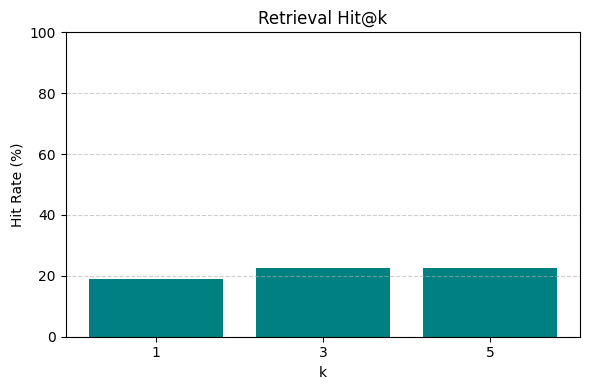

In [41]:
plt.figure(figsize=(6,4))
plt.bar([str(k) for k in k_values], [hit_rates[k]*100 for k in k_values], color="teal")
plt.ylabel("Hit Rate (%)")
plt.xlabel("k")
plt.title("Retrieval Hit@k")
plt.ylim(0,100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("retrieval_hit@k.png", dpi=200)
plt.show()

## Generator on No options

### Imports & config

In [ ]:
import os, json, re, unicodedata
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
from tqdm import tqdm
from openai import OpenAI 

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
  # ----------------------------
# Paths
# ----------------------------
BASE       = Path(".")
OUT_DIR    = Path(".")

QUESTIONS_JSON = Path("uni_questions_110.json")
DOCS_MAP       = OUT_DIR / "docs.jsonl"                 
OPENQA_OUT_CSV = OUT_DIR / "openqa_generative_outputs.csv"

# ----------------------------
# Load data
# ----------------------------
questions: List[Dict[str, Any]] = json.loads(QUESTIONS_JSON.read_text(encoding="utf-8"))
docs = [json.loads(line) for line in DOCS_MAP.open("r", encoding="utf-8")]
print(f"Loaded {len(questions)} questions | {len(docs)} docs")

Loaded 110 questions | 4092 docs


### Data loading and helper function

In [ ]:
CACHE_JSON = Path("openqa_cached_top3.json")

questions = json.loads(QUESTIONS_JSON.read_text(encoding="utf-8"))
print("Questions:", len(questions))

all_rows = []
for ex in tqdm(questions, desc="Caching top-3 retrievals"):
    q   = ex["question"]
    ans = ex.get("answer", "")
    cat = ex.get("category", "")
    hits = search(q, k=3)  
    ctxs = []
    for h in hits:
        ctxs.append({
            "name": h.get("name", ""),
            "summary": h.get("summary", ""),
            "score": float(h.get("_score", 0.0))
        })
    all_rows.append({
        "question": q,
        "gold_answer": ans,
        "category": cat,
        "top3_contexts": ctxs
    })

with CACHE_JSON.open("w", encoding="utf-8") as f:
    json.dump(all_rows, f, ensure_ascii=False, indent=2)

print(f"✅ Cached retrievals saved to {CACHE_JSON}")

Questions: 110


Caching top-3 retrievals: 100%|██████████| 110/110 [00:01<00:00, 63.17it/s]

✅ Cached retrievals saved to openqa_cached_top3.json


In [ ]:
# ----------------------------
# Paths & Data Loading
# ----------------------------
CACHE_JSON = Path("openqa_cached_top3.json")
assert CACHE_JSON.exists(), f"Cached file not found: {CACHE_JSON}"

questions = json.loads(CACHE_JSON.read_text(encoding="utf-8"))
print(f"Loaded {len(questions)} cached Qs with retrievals")

# مسیر خروجی
OUT_RUN_DIR = Path("artifacts/unimodal/runs")
OUT_RUN_DIR.mkdir(parents=True, exist_ok=True)
OPENQA_OUT_CSV = OUT_RUN_DIR / "openqa_outputs.csv"

# ----------------------------
# API Client
# ----------------------------
GAPGPT_API_KEY = os.getenv("GAPGPT_API_KEY") or "sk-<YOUR_KEY>"
client = OpenAI(base_url="https://api.gapgpt.app/v1", api_key=GAPGPT_API_KEY)
MODEL  = "gpt-4o-mini"

# ----------------------------
# Helpers
# ----------------------------
def trim(s: str, max_chars: int = 1400) -> str:
    s = (s or "").strip()
    return s if len(s) <= max_chars else (s[:max_chars] + "…")

def build_prompt_persian(question: str, ctxs: List[Dict[str,str]]) -> List[Dict[str,str]]:
    k = max(1, len(ctxs))
    task = (
        "تو یک مولد پاسخ مبتنی بر RAG هستی. فقط از متون زمینهٔ زیر استفاده کن و اگر پاسخ در آن‌ها نبود، "
        "بگو «نمی‌دانم».\n"
        "خروجی فقط JSON با ساختار:\n"
        '{ "target_name": "", "answer_text": "", "evidence_span": "" }'
    )
    ctx_block = "\n\n".join(
        f"[{i+1}] نام: {c.get('name','')}\n{trim(c.get('summary',''))}" for i,c in enumerate(ctxs)
    ) or "هیچ متنی موجود نیست."
    user = f"{task}\n\nسؤال:\n{question}\n\n---\nاسناد بازیابی‌شده (top-{k}):\n{ctx_block}\n\nفقط JSON پاسخ بده."
    return [
        {"role":"system","content":"You are a helpful assistant. Answer ONLY in JSON."},
        {"role":"user","content": user}
    ]

def call_model(messages: List[Dict[str,str]]) -> Dict[str,Any]:
    resp = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        response_format={"type":"json_object"}
    )
    txt = (resp.choices[0].message.content or "").strip()
    if txt.startswith("```"):
        txt = re.sub(r"^```(?:json)?\s*|\s*```$", "", txt, flags=re.DOTALL)
    try:
        obj = json.loads(txt)
    except Exception:
        obj = {"target_name":"", "answer_text":"", "evidence_span":txt}
    for key in ["target_name","answer_text","evidence_span"]:
        obj.setdefault(key, "")
    return obj

### Run main loop (API)

In [ ]:
# ----------------------------
# Run generation using cached retrievals
# ----------------------------
rows = []
for ex in tqdm(questions, desc="Generating answers"):
    q     = ex.get("question","").strip()
    cat   = ex.get("category","")
    gold  = ex.get("gold_answer","") or ex.get("answer","")
    ctxs  = ex.get("top3_contexts", [])
    msgs  = build_prompt_persian(q, ctxs)
    result = call_model(msgs)
    rows.append({
        "question": q,
        "category": cat,
        "gold_answer": gold,
        "target_name": result.get("target_name",""),
        "answer_text": result.get("answer_text",""),
        "evidence_span": result.get("evidence_span",""),
        "ctx_names": [c.get("name","") for c in ctxs]
    })

# Save outputs
df = pd.DataFrame(rows)
df.to_csv(OPENQA_OUT_CSV, index=False, encoding="utf-8")
print("✅ Saved generative outputs →", OPENQA_OUT_CSV)

Loaded 110 cached Qs with retrievals


Generating answers: 100%|██████████| 110/110 [04:14<00:00,  2.32s/it]

✅ Saved generative outputs → artifacts\unimodal\runs\openqa_outputs.csv


In [4]:
pd.set_option("display.max_rows", None)
df

,question,category,gold_answer,target_name,answer_text,evidence_span,ctx_names
0,حبیب‌الله بلور در کدام رشته ورزشی فعالیت داشت؟,athlete,کشتی,حبیب‌الله بلور,کشتی,حبیب‌الله بلور، ورزشکار کشتی، در تاریخ 5 فرورد...,"[حبیب‌الله بلور, حبیب‌الله بلور, حبیب‌الله اخل..."
1,بهرنگ صفری در چه سالی متولد شده است؟,athlete,۱۳۶۳,بهرنگ صفری,1363,بهرنگ صفری، ورزشکار فوتبال، در تاریخ 20 بهمن 1...,"[بهرنگ صفری, سعید صفری, شکوفه صفری]"
2,عبدالله موحد چند مدال جهانی کسب کرده است؟,athlete,۵,عبدالله موحد,عبدالله موحد 5 مدال جهانی کسب کرده است.,او 5 مدال جهانی، 2 مدال منطقه‌ای، و یک مدال ال...,"[عبدالله موحد, علی‌اکبر موسوی موحدی, بهادر مول..."
3,لوون کورکچیان مدال طلای خود را در کدام رقابت ک...,athlete,بازی‌های آسیایی ۱۹۵۱ دهلی نو,لوون کورکچیان,بازی‌های آسیایی 1951 دهلی‌نو,افتخار مدال طلا بازی‌های آسیایی 1951 دهلی‌نو ر...,"[لوون کورکچیان, ساره جوانمردی, علی اشکوریان]"
4,علیرضا حقی در چه ماهی متولد شده است؟,athlete,فوریهٔ ۱۹۷۹,علیرضا حقی,در تاریخ 8 فوریه 1979 متولد شده است.,علیرضا حقی، ورزشکار دوچرخه‌سواری، در تاریخ 8 ف...,"[علیرضا حقی, علیرضا محمدی, علیرضا حقیقی]"
5,زوونیمیر سولدو در کدام کشور متولد شده است؟,athlete,کرواسی,زوونیمیر سولدو,نمی‌دانم,,"[زوونیمیر سولدو, آلمدین زیلیکیچ, آندره رینالدو]"
6,محراب شاهرخی در چه سالی درگذشته است؟,athlete,۱۳۷۱,محراب شاهرخی,محراب شاهرخی در تاریخ 12 بهمن 1371 درگذشته است.,محراب شاهرخی، ورزشکار فوتبال، در تاریخ 12 بهمن...,"[محراب شاهرخی, ازرقی هروی, سهراب سپهری]"
7,وزن محمد جمشیدی چند کیلوگرم است؟,athlete,۸۰,محمد جمشیدی,80 کیلوگرم,محمد جمشیدی، ورزشکار بسکتبال، در تاریخ 30 ژوئی...,"[محمد جمشیدی , بهروز جمشیدی, محمد شهریان]"
8,مجتبی گلیج در کدام شهر متولد شده است؟,athlete,تنکابن,مجتبی گلیج,تنکابن,مجتبی گلیج، ورزشکار کشتی، در تاریخ 3 بهمن 1375...,"[مجتبی گلیج, مجتبی حق‌دوست, محمدعلی زلفی‌گل]"
9,قد ایمان موسوی چند است؟,athlete,۱/۸۴,ایمان موسوی,قد ایشان 1 / 84 است,ایمان موسوی، ورزشکار فوتبال، در تاریخ 16 بهمن ...,"[ایمان موسوی, محمد موسوی, احمد موسوی]"


## LLM as a Judge idea

In [ ]:
# ===================== CONFIG =====================
GAPGPT_API_KEY = os.getenv("GAPGPT_API_KEY") or "sk-..."
client = OpenAI(base_url="https://api.gapgpt.app/v1", api_key=GAPGPT_API_KEY)
MODEL  = "gpt-4o-mini"

In [ ]:
def build_judge_prompt(question: str, gold: str, pred: str) -> list[dict]:
    user = (
        "سؤال زیر و دو پاسخ را ببین. اگر دو پاسخ از نظر معنایی یکسان یا معادل باشند، فقط «1» بده؛ "
        "اگر معادل نباشند فقط «0» بده. هیچ توضیحی نده.\n\n"
        f"سؤال:\n{question}\n\n"
        f"پاسخ طلایی:\n{gold}\n\n"
        f"پاسخ مدل:\n{pred}"
    )
    return [
        {"role": "system", "content": "You are a strict evaluator. Answer with only '0' or '1'."},
        {"role": "user",   "content": user},
    ]

def call_judge(messages: list[dict]) -> int:
    resp = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        temperature=0,
        max_tokens=4
    )
    txt = (resp.choices[0].message.content or "").strip()
    txt = re.sub(r"[^\d]", "", txt)
    return 1 if txt.startswith("1") else 0

In [ ]:
# ===================== RUN =====================
judge_results = []
for _, r in tqdm(df.iterrows(), total=len(df), desc="Judging"):
    q = r.get("question", "")
    gold = r.get("gold_answer", "")
    pred = r.get("answer_text", "")
    msgs = build_judge_prompt(q, gold, pred)
    j = call_judge(msgs)
    judge_results.append(j)

df["judge_match"] = judge_results

out_path = Path("artifacts/unimodal/runs/openqa_with_judge.csv")
df.to_csv(out_path, index=False, encoding="utf-8")
print(f"Saved with judge column → {out_path}")
print("LLM-as-judge Accuracy:", df["judge_match"].mean())


Judging: 100%|██████████| 110/110 [01:21<00:00,  1.35it/s]

Saved with judge column → artifacts\unimodal\runs\openqa_with_judge.csv
LLM-as-judge Accuracy: 0.7727272727272727


In [7]:
df

,question,category,gold_answer,target_name,answer_text,evidence_span,ctx_names,judge_match
0,حبیب‌الله بلور در کدام رشته ورزشی فعالیت داشت؟,athlete,کشتی,حبیب‌الله بلور,کشتی,حبیب‌الله بلور، ورزشکار کشتی، در تاریخ 5 فرورد...,"[حبیب‌الله بلور, حبیب‌الله بلور, حبیب‌الله اخل...",1
1,بهرنگ صفری در چه سالی متولد شده است؟,athlete,۱۳۶۳,بهرنگ صفری,1363,بهرنگ صفری، ورزشکار فوتبال، در تاریخ 20 بهمن 1...,"[بهرنگ صفری, سعید صفری, شکوفه صفری]",1
2,عبدالله موحد چند مدال جهانی کسب کرده است؟,athlete,۵,عبدالله موحد,عبدالله موحد 5 مدال جهانی کسب کرده است.,او 5 مدال جهانی، 2 مدال منطقه‌ای، و یک مدال ال...,"[عبدالله موحد, علی‌اکبر موسوی موحدی, بهادر مول...",1
3,لوون کورکچیان مدال طلای خود را در کدام رقابت ک...,athlete,بازی‌های آسیایی ۱۹۵۱ دهلی نو,لوون کورکچیان,بازی‌های آسیایی 1951 دهلی‌نو,افتخار مدال طلا بازی‌های آسیایی 1951 دهلی‌نو ر...,"[لوون کورکچیان, ساره جوانمردی, علی اشکوریان]",1
4,علیرضا حقی در چه ماهی متولد شده است؟,athlete,فوریهٔ ۱۹۷۹,علیرضا حقی,در تاریخ 8 فوریه 1979 متولد شده است.,علیرضا حقی، ورزشکار دوچرخه‌سواری، در تاریخ 8 ف...,"[علیرضا حقی, علیرضا محمدی, علیرضا حقیقی]",1
5,زوونیمیر سولدو در کدام کشور متولد شده است؟,athlete,کرواسی,زوونیمیر سولدو,نمی‌دانم,,"[زوونیمیر سولدو, آلمدین زیلیکیچ, آندره رینالدو]",0
6,محراب شاهرخی در چه سالی درگذشته است؟,athlete,۱۳۷۱,محراب شاهرخی,محراب شاهرخی در تاریخ 12 بهمن 1371 درگذشته است.,محراب شاهرخی، ورزشکار فوتبال، در تاریخ 12 بهمن...,"[محراب شاهرخی, ازرقی هروی, سهراب سپهری]",1
7,وزن محمد جمشیدی چند کیلوگرم است؟,athlete,۸۰,محمد جمشیدی,80 کیلوگرم,محمد جمشیدی، ورزشکار بسکتبال، در تاریخ 30 ژوئی...,"[محمد جمشیدی , بهروز جمشیدی, محمد شهریان]",1
8,مجتبی گلیج در کدام شهر متولد شده است؟,athlete,تنکابن,مجتبی گلیج,تنکابن,مجتبی گلیج، ورزشکار کشتی، در تاریخ 3 بهمن 1375...,"[مجتبی گلیج, مجتبی حق‌دوست, محمدعلی زلفی‌گل]",1
9,قد ایمان موسوی چند است؟,athlete,۱/۸۴,ایمان موسوی,قد ایشان 1 / 84 است,ایمان موسوی، ورزشکار فوتبال، در تاریخ 16 بهمن ...,"[ایمان موسوی, محمد موسوی, احمد موسوی]",1


### Running some eval metrics on final df

In [ ]:
# === 1) Load results ===
csv_path = Path("artifacts/unimodal/runs/openqa_with_judge.csv")
df = pd.read_csv(csv_path)

# make sure judge_match is numeric
df["judge_match"] = pd.to_numeric(df["judge_match"], errors="coerce").fillna(0).astype(int)

In [ ]:
# === 2) Overall accuracy ===
overall_acc = df["judge_match"].mean()
print(f"Overall accuracy: {overall_acc:.3f}")

plt.figure(figsize=(4,4))
plt.bar(["Accuracy"], [overall_acc], color="teal")
plt.ylim(0,1)
plt.title("Overall Accuracy")
plt.ylabel("Accuracy")
plt.savefig("overall_accuracy.png", dpi=150, bbox_inches="tight")
plt.close()

In [ ]:
# === 3) Accuracy by category ===
cat_acc = df.groupby("category")["judge_match"].mean().sort_values()
plt.figure(figsize=(8,5))
sns.barplot(x=cat_acc.index, y=cat_acc.values, palette="viridis")
plt.xticks(rotation=60, ha="right")
plt.ylabel("Accuracy")
plt.title("Accuracy by Category")
plt.tight_layout()
plt.savefig("accuracy_by_category.png", dpi=150)
plt.close()

In [ ]:
# === 4) Count of questions per category ===
cat_count = df["category"].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=cat_count.index, y=cat_count.values, palette="Set2")
plt.xticks(rotation=60, ha="right")
plt.ylabel("Number of Questions")
plt.title("Question Count by Category")
plt.tight_layout()
plt.savefig("count_by_category.png", dpi=150)
plt.close()

In [ ]:
# === 5) Gold vs. predicted answer length analysis ===
df["gold_len"] = df["gold_answer"].astype(str).str.len()
df["pred_len"] = df["answer_text"].astype(str).str.len()
df["len_diff"] = (df["pred_len"] - df["gold_len"]).abs()

plt.figure(figsize=(6,4))
sns.histplot(df["len_diff"], bins=20, color="orchid", kde=False)
plt.xlabel("|Predicted length – Gold length|")
plt.ylabel("Frequency")
plt.title("Length Difference Distribution")
plt.tight_layout()
plt.savefig("length_difference_distribution.png", dpi=150)
plt.close()

In [ ]:
# === 6) Accuracy vs. gold answer length buckets ===
df["gold_len_bucket"] = pd.cut(df["gold_len"], bins=[0,20,40,60,100,200],
                               labels=["0-20","21-40","41-60","61-100","101-200"])
bucket_acc = df.groupby("gold_len_bucket")["judge_match"].mean()
plt.figure(figsize=(7,4))
sns.barplot(x=bucket_acc.index, y=bucket_acc.values, palette="coolwarm")
plt.ylabel("Accuracy")
plt.title("Accuracy by Gold Answer Length Bucket")
plt.tight_layout()
plt.savefig("accuracy_vs_gold_length.png", dpi=150)
plt.close()

In [ ]:
# === 7) Heatmap: category vs. length bucket ===
pivot = pd.pivot_table(
    df, index="category", columns="gold_len_bucket",
    values="judge_match", aggfunc="mean"
)
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Accuracy Heatmap: Category × Gold Length")
plt.tight_layout()
plt.savefig("heatmap_category_vs_length.png", dpi=150)
plt.close()

In [ ]:
print("✅ Plots saved as:")
print("  overall_accuracy.png")
print("  accuracy_by_category.png")
print("  count_by_category.png")
print("  length_difference_distribution.png")
print("  accuracy_vs_gold_length.png")
print("  heatmap_category_vs_length.png")

Overall accuracy: 0.773


c:\Users\danes\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danes\AppData\Local\Temp\ipykernel_23336\1175286584.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_acc = df.groupby("gold_len_bucket")["judge_match"].mean()
c:\Users\danes\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\danes\Ap

✅ Plots saved as:
  overall_accuracy.png
  accuracy_by_category.png
  count_by_category.png
  length_difference_distribution.png
  accuracy_vs_gold_length.png
  heatmap_category_vs_length.png
